# Telecom Churn Prediction - Starter Notebook

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [72]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# setting different colors for matplotlib for better visualisation
custom_colors = ["#67E568","#257F27","#08420D","#FFF000","#FFB62B","#E56124","#E53E30","#7F2353","#F911FF","#9F8CA6"]
pastel_colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [3]:
raw_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
data_dict = pd.read_csv("data_dictionary.csv")
output = pd.read_csv("sample.csv")

#Checking the kaggle paths for the uploaded datasets
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [4]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

print(raw_data.shape)
print(test_data.shape)
print(output.shape)
print(data_dict.shape)

raw_data.head()

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

# 2. Exploratory Data Analysis
Let us first look at the data dictionary to understand the variables in the dataset.
We will then split the data set into categorical and numerical variables and perform EDA on each of them separately.

In [5]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

## 2.1. Categorical variables
We know that the categorical variables are the ones that are of type object. Let us look at the categorical variables in our dataset.
And we'll also get the numerical variables from the data set.

First thing however is to see if there are any missing values in the data set. We can use the missingno library to visualize the missing values in the data set.

<AxesSubplot:>

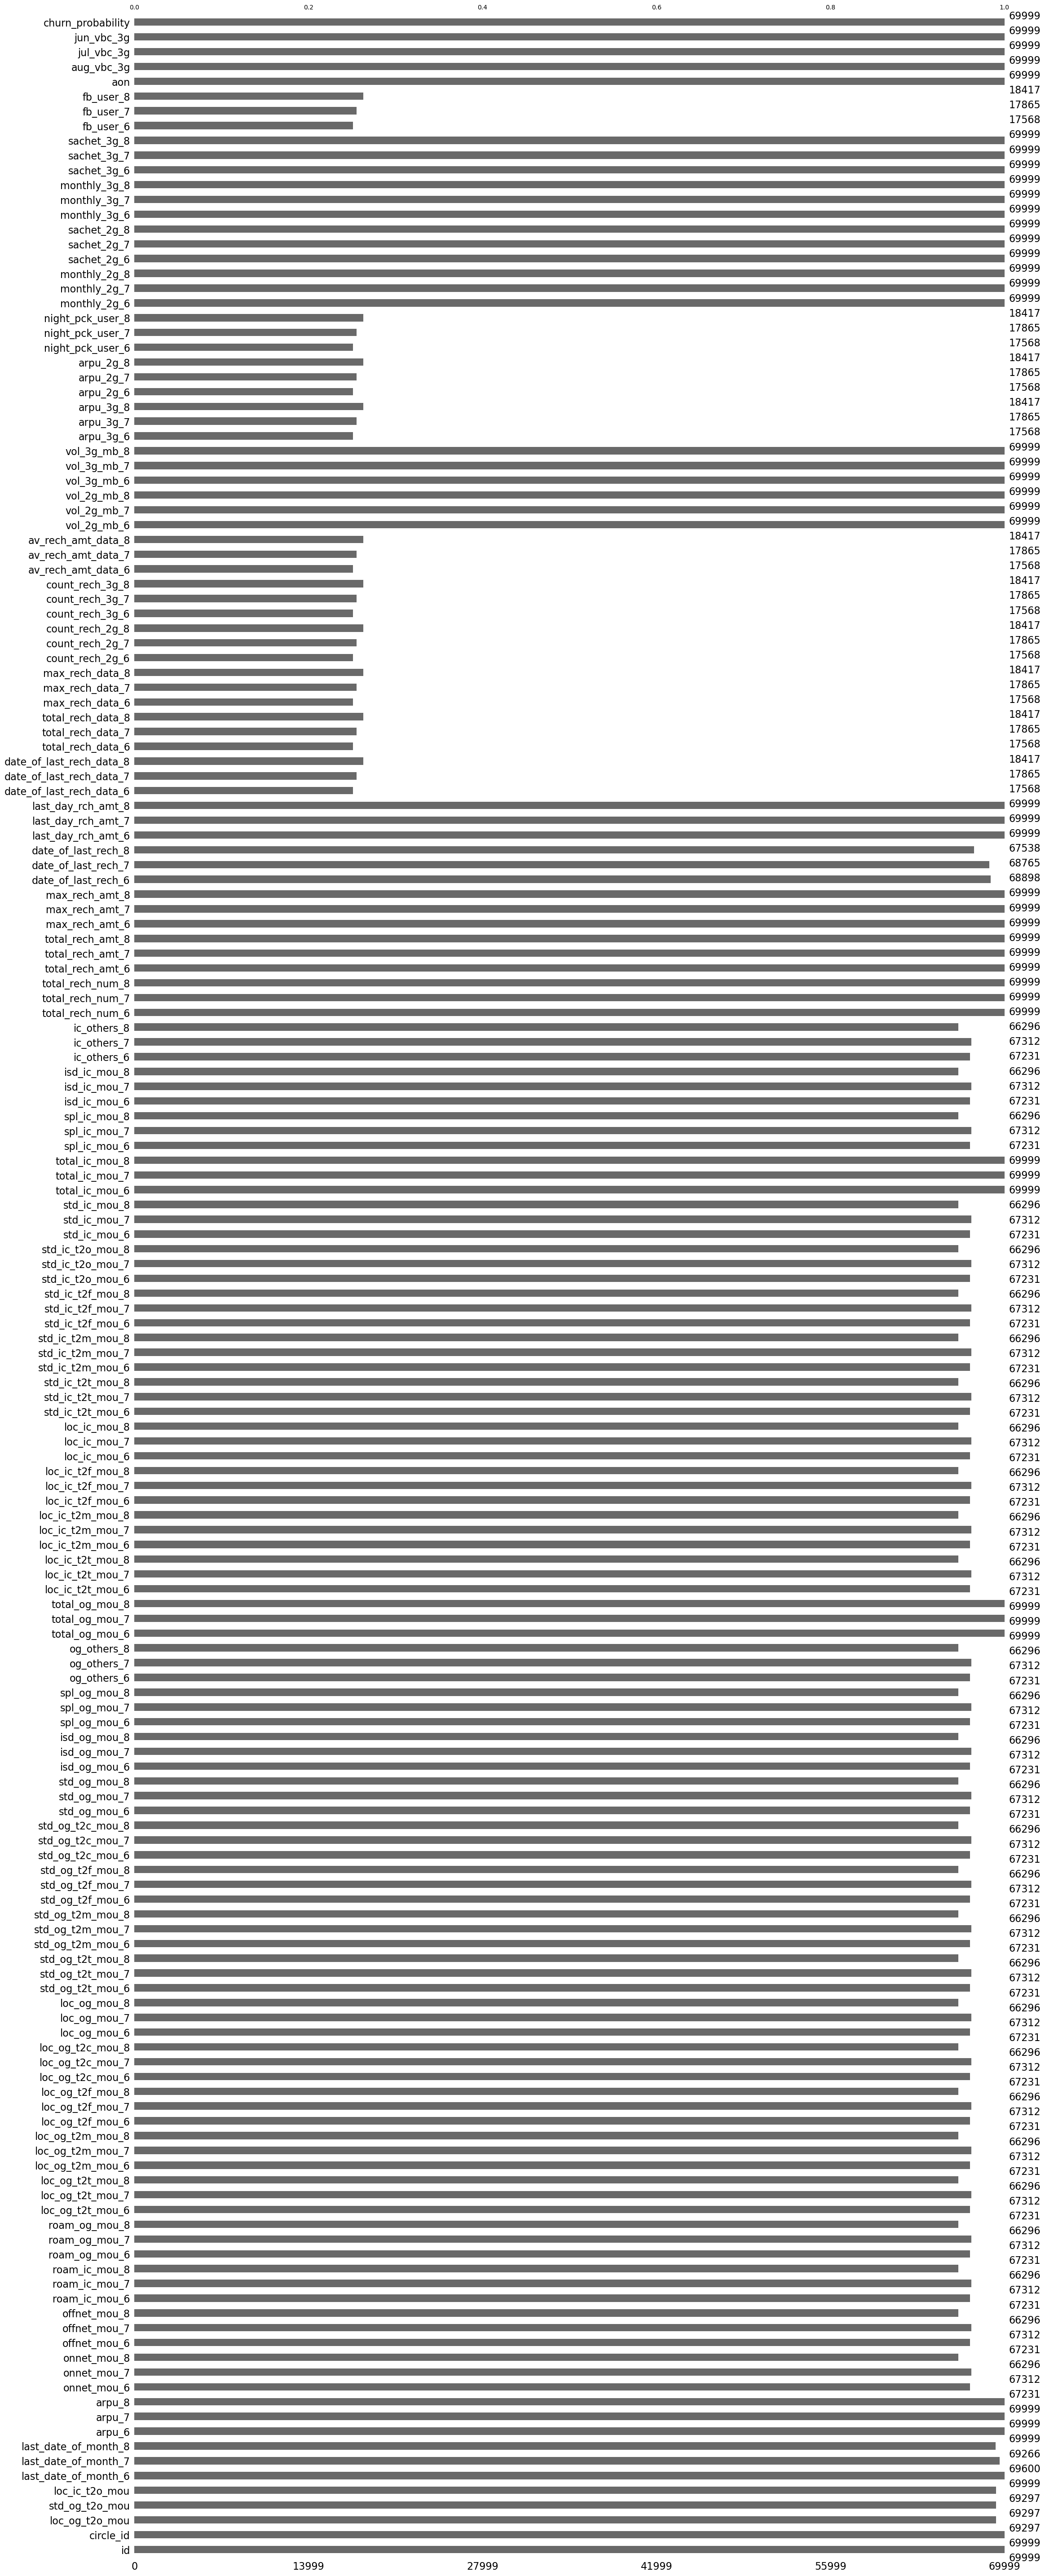

In [6]:
#Checking for missing values
msno.bar(raw_data)


In [7]:
# That suggests we have a lot of missing values in the data set. Let us look at the percentage of missing values in each column.
# We will only look at the columns that have missing values.
# Let us sort the columns by the percentage of missing values in each column in descending order.
raw_data.isnull().sum()[raw_data.isnull().sum()>0].sort_values(ascending=False)/raw_data.shape[0]*100 #Percentage of missing values in each column

max_rech_data_6             74.902499
fb_user_6                   74.902499
date_of_last_rech_data_6    74.902499
av_rech_amt_data_6          74.902499
night_pck_user_6            74.902499
                              ...    
last_date_of_month_8         1.047158
std_og_t2o_mou               1.002871
loc_ic_t2o_mou               1.002871
loc_og_t2o_mou               1.002871
last_date_of_month_7         0.570008
Length: 125, dtype: float64

In [8]:
# Let us look at the types of the columns with large number of missing values in the data set.
# Let us write a one liner to retrieve the name of the column and the associated type for all
# columns with any missing values
raw_data[raw_data.isnull().sum()[raw_data.isnull().sum()>0].index].dtypes


loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_7     object
last_date_of_month_8     object
                         ...   
night_pck_user_7        float64
night_pck_user_8        float64
fb_user_6               float64
fb_user_7               float64
fb_user_8               float64
Length: 125, dtype: object

In [9]:
# Let us split these columns into two sets, numerical and categorical and impute the missing values separately for each set.
numerical_columns_with_nan, categorical_columns_with_nan = [col for col in raw_data.columns[raw_data.isna().any()] if np.issubdtype(raw_data[col].dtype, np.number)], [col for col in raw_data.columns[raw_data.isna().any()] if pd.api.types.is_string_dtype(raw_data[col])]

print(numerical_columns_with_nan)
print(categorical_columns_with_nan)


['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_m

### 2.1.1. Categorical variables with missing values imputation
We seem to have a reasonably large number of categorical variables with missing values. Let us look at the percentage of missing values in each of these columns.


<AxesSubplot:>

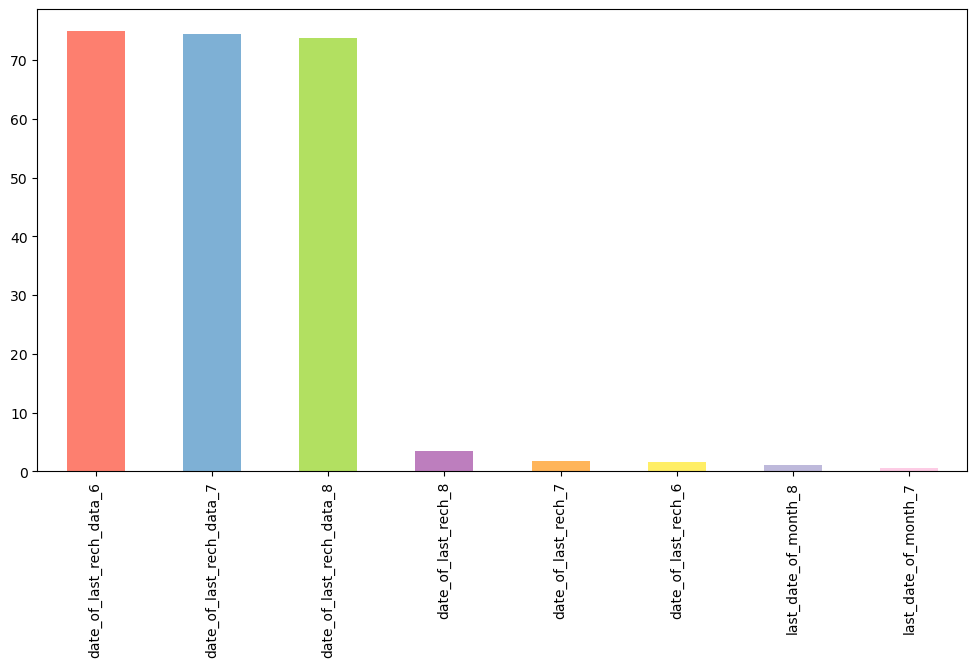

In [10]:
missing_values_percent = raw_data[categorical_columns_with_nan].isnull().mean() * 100
missing_values_percent.sort_values(ascending=False).plot.bar(figsize=(12,6), color=pastel_colors)

In [11]:
# last date of the month can be imputed but these columns are of no consequence to us. So we can drop all columns that match the pattern last_date_of_month_*
raw_data = raw_data.drop(columns=raw_data.filter(regex='last_date_of_month_*').columns)
raw_data.shape

(69999, 169)

In [12]:
# In my opinion date of last recharge is irrelevant as the last recharge amounts are also available in the data set for each
# of the previous months. So we can drop all columns that match the pattern date_of_last_rech_*.
raw_data = raw_data.drop(columns=raw_data.filter(regex='date_of_last_rech_*').columns)
raw_data.shape

(69999, 163)

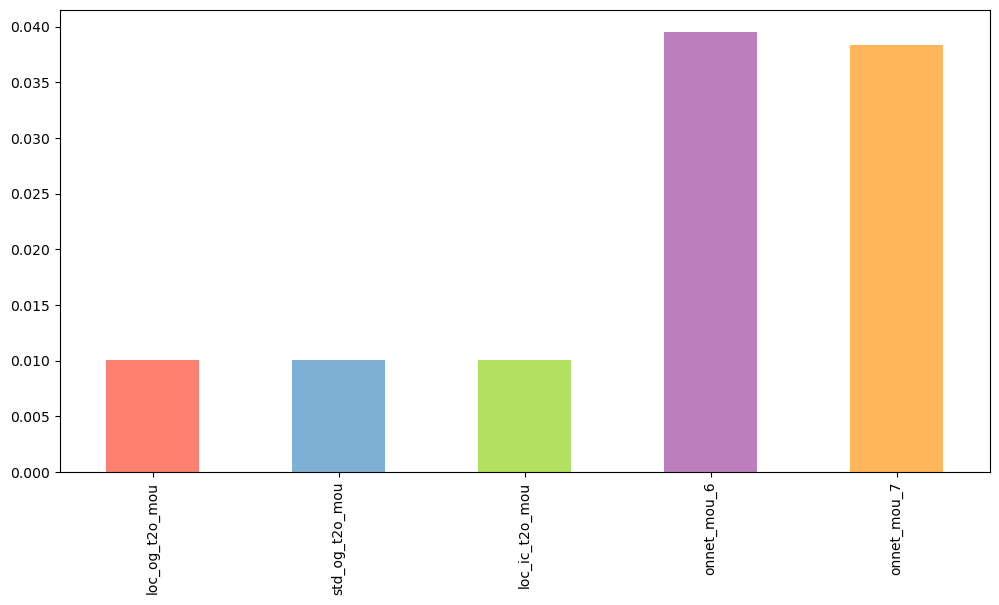

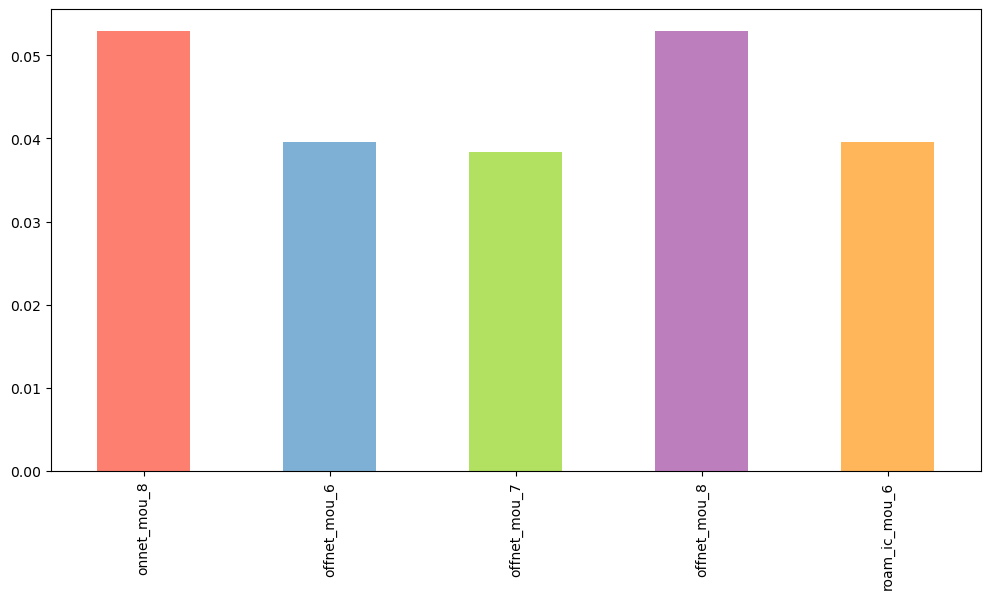

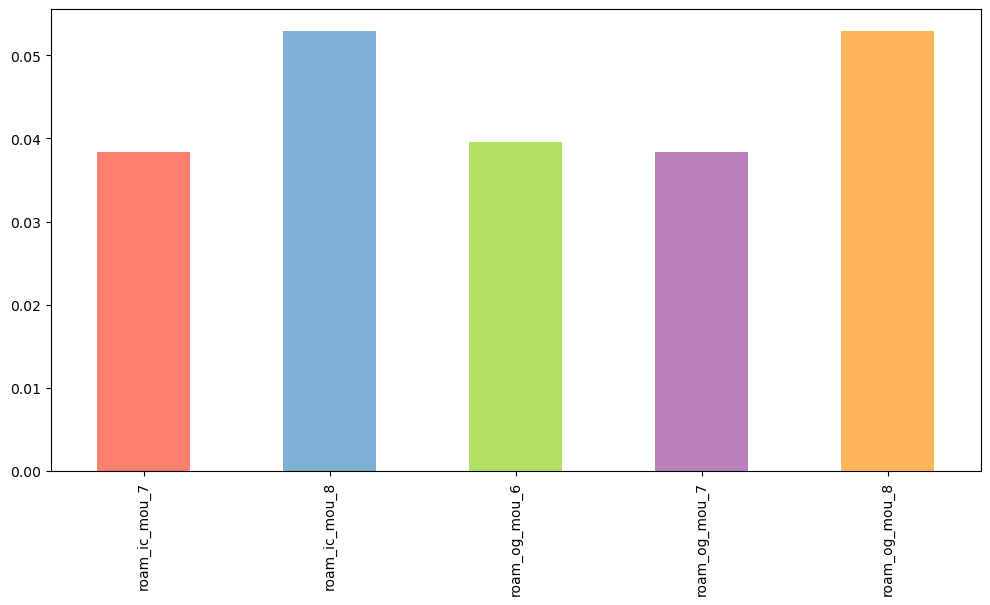

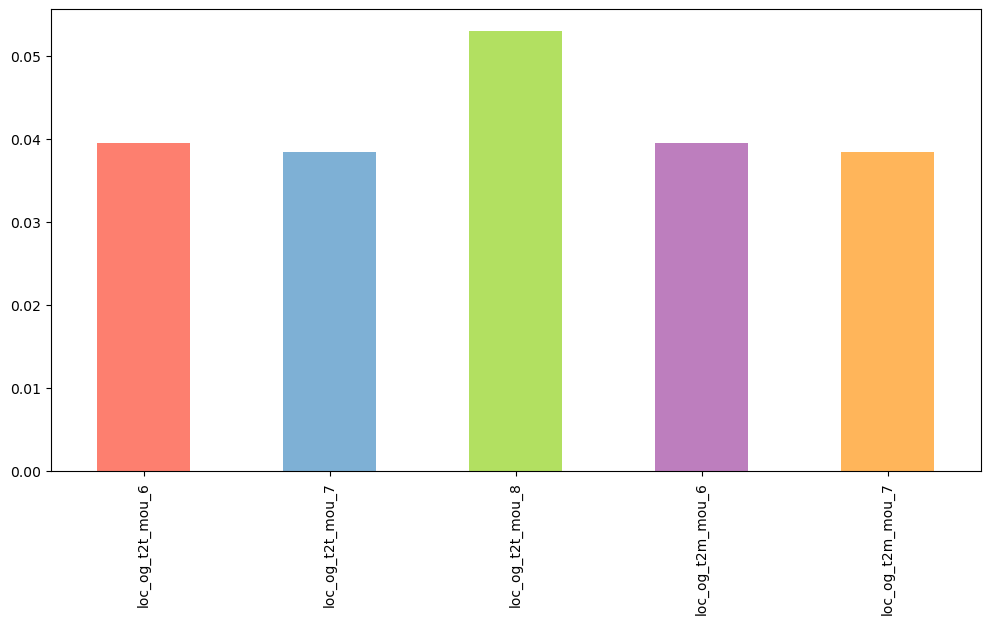

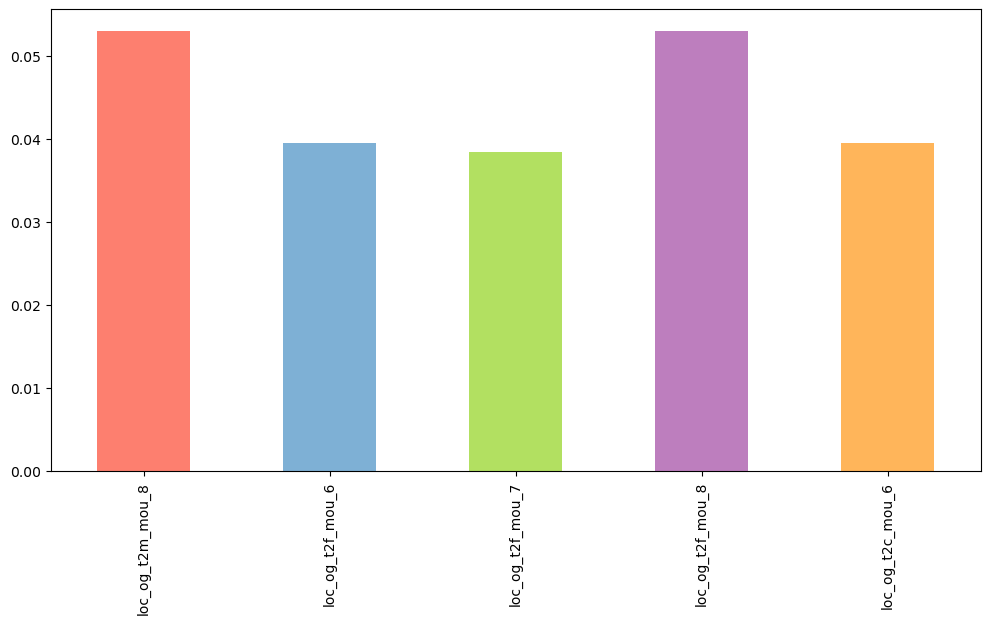

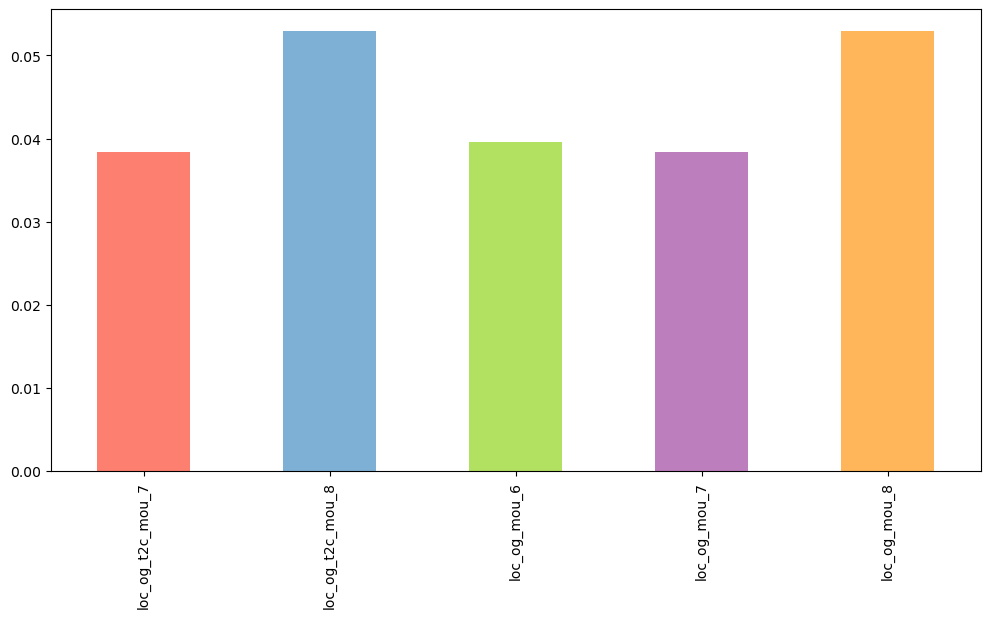

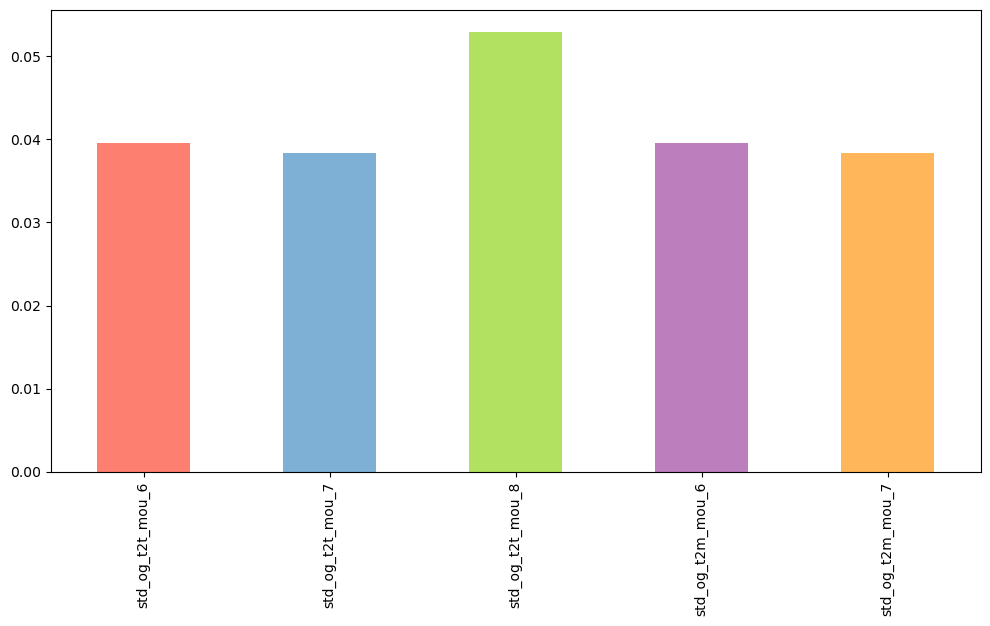

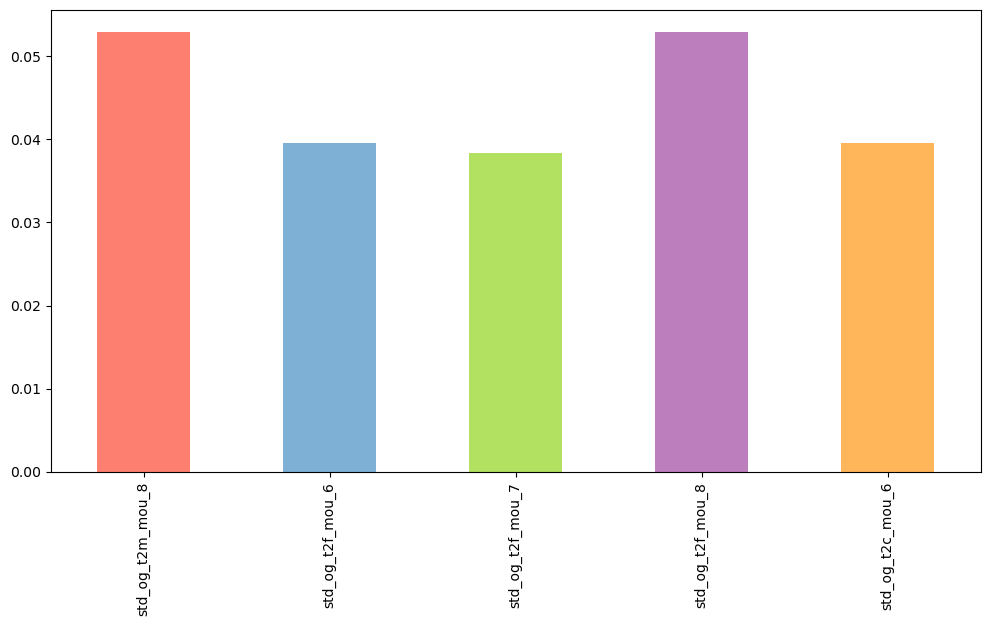

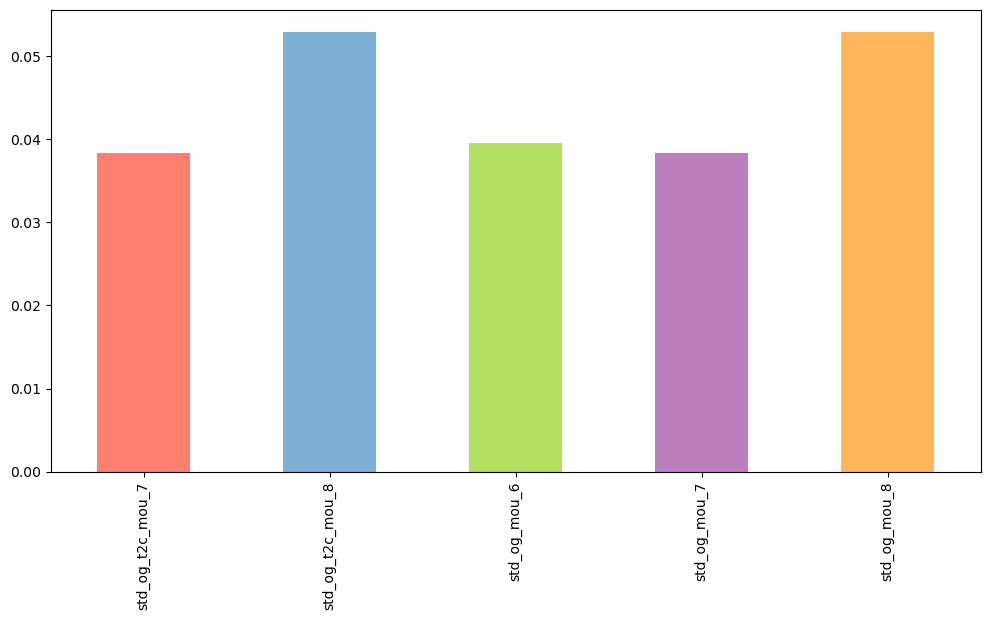

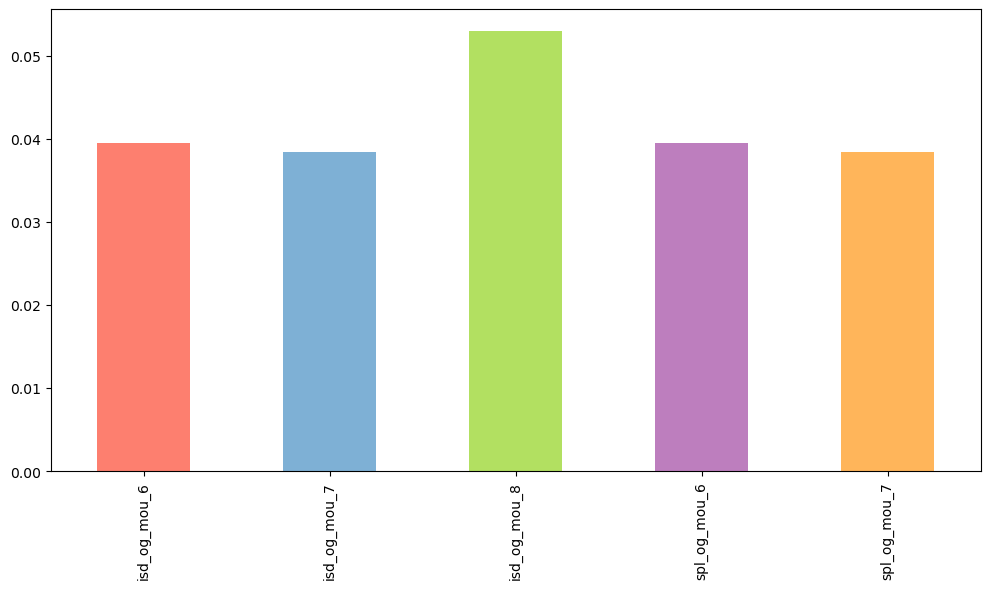

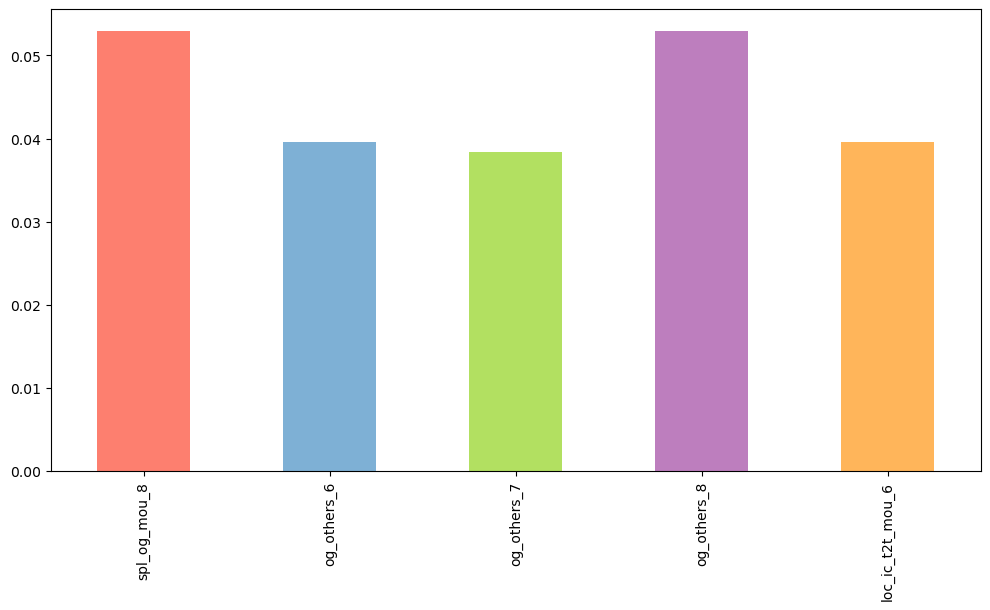

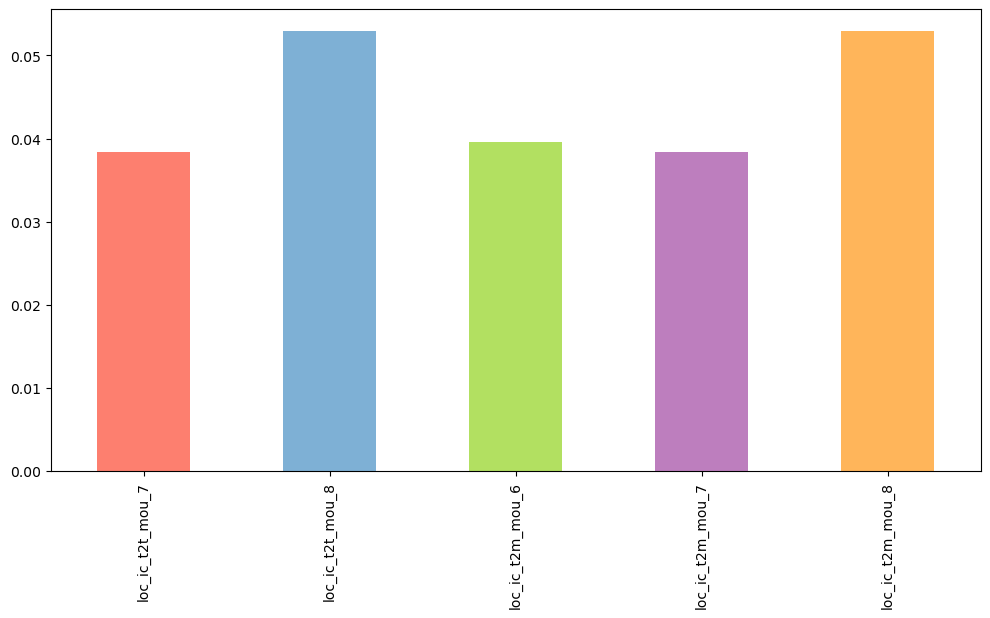

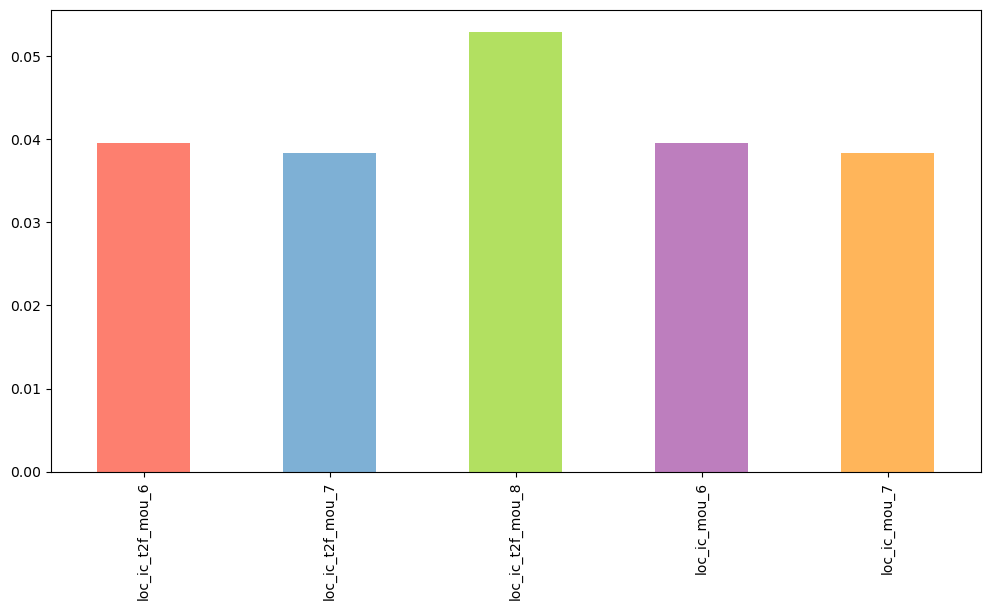

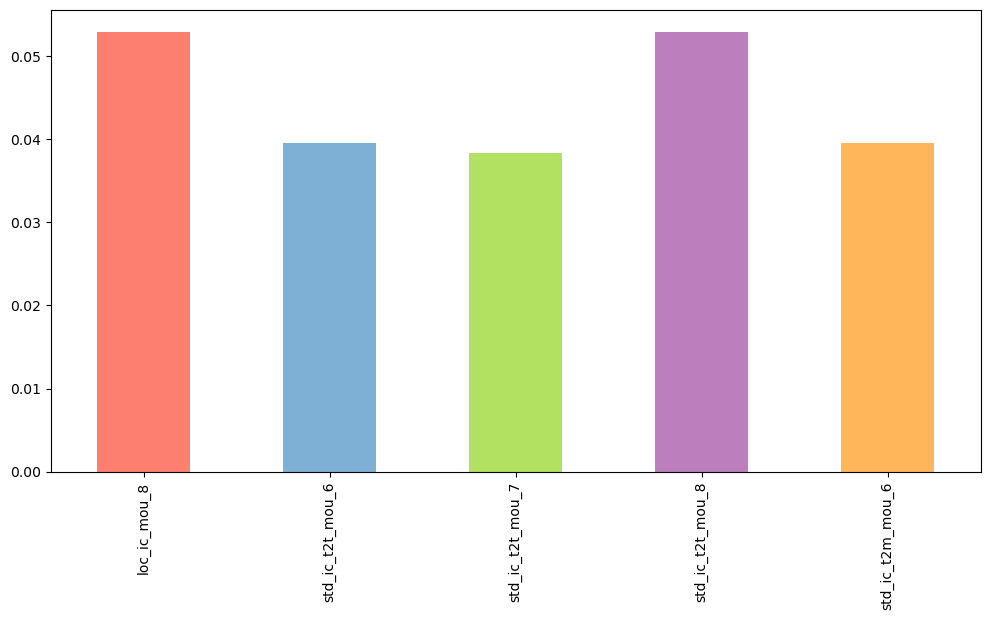

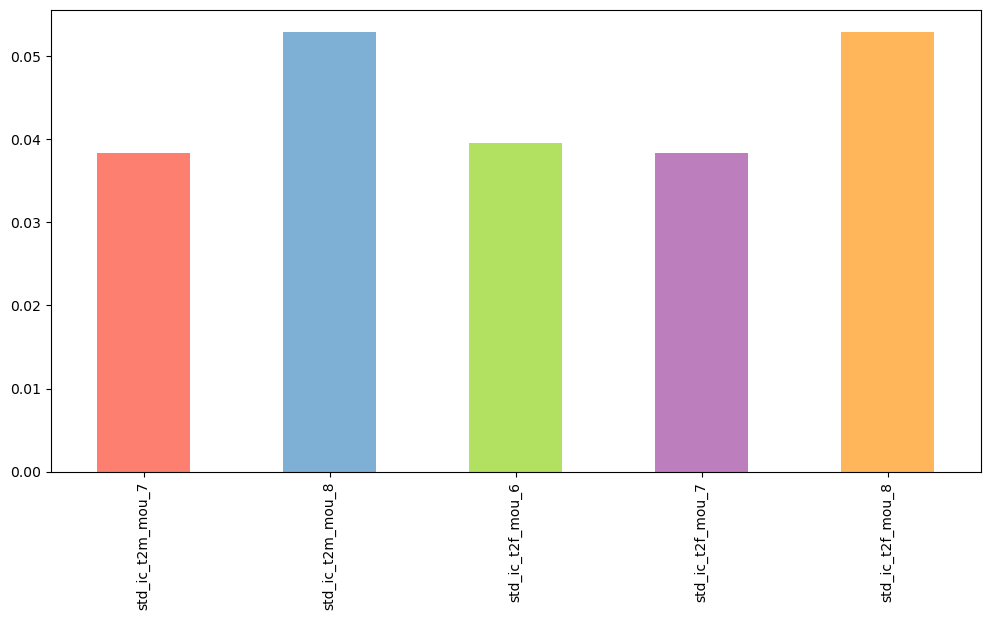

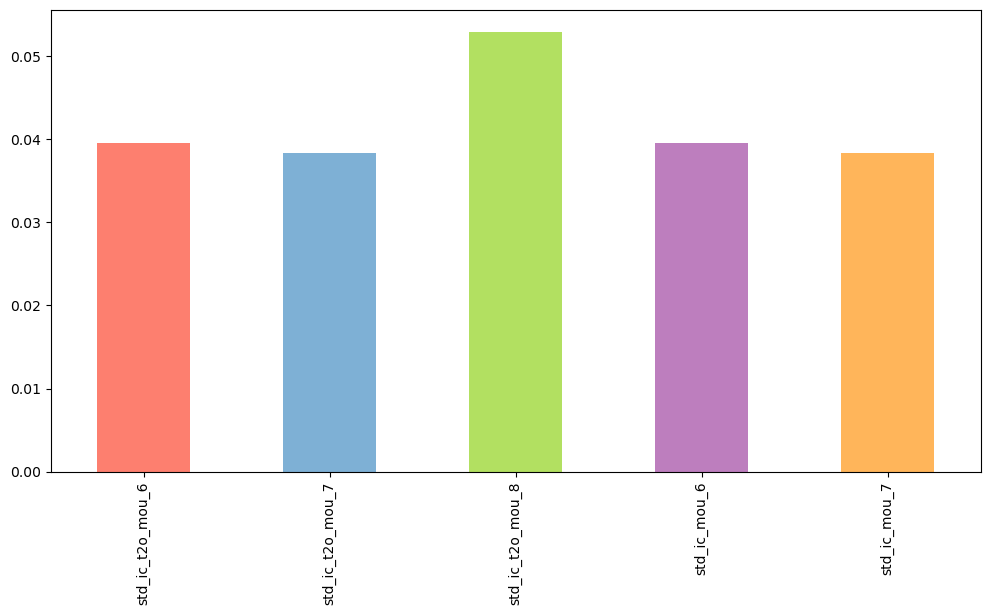

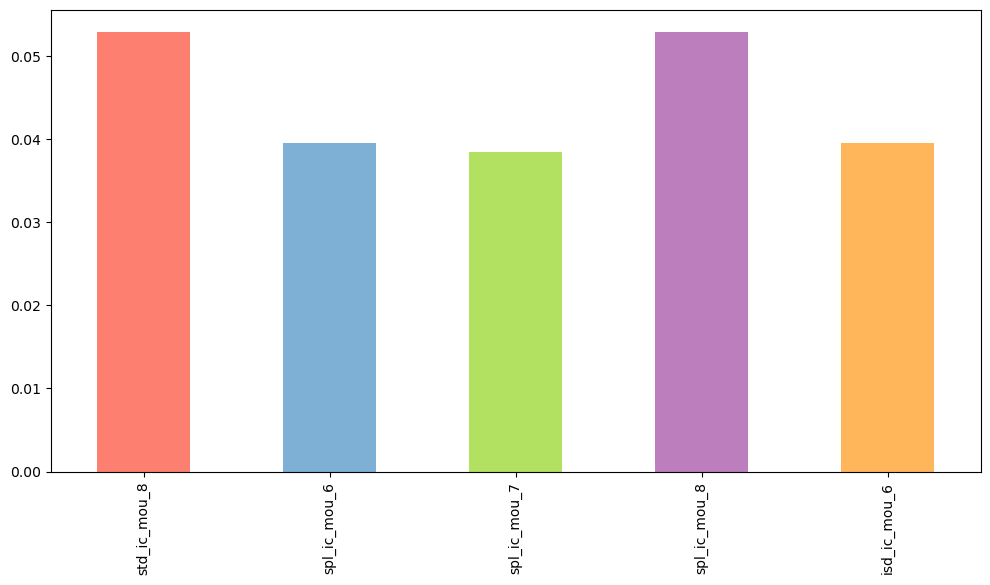

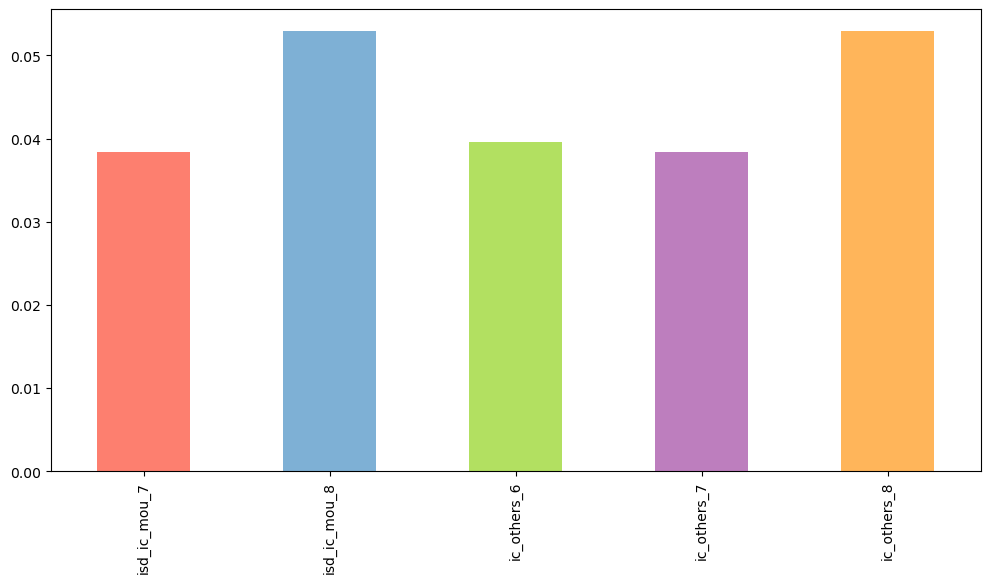

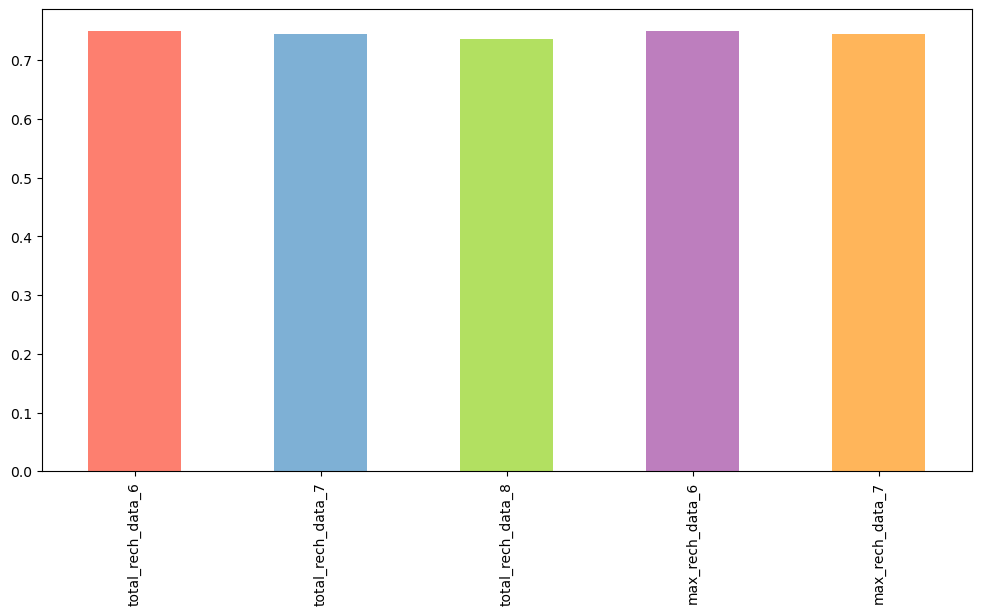

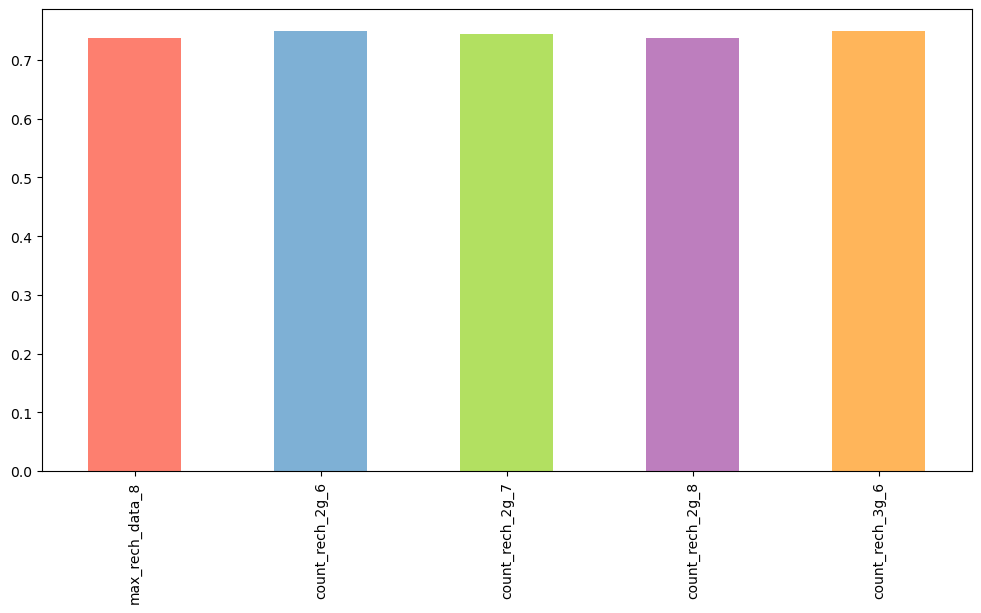

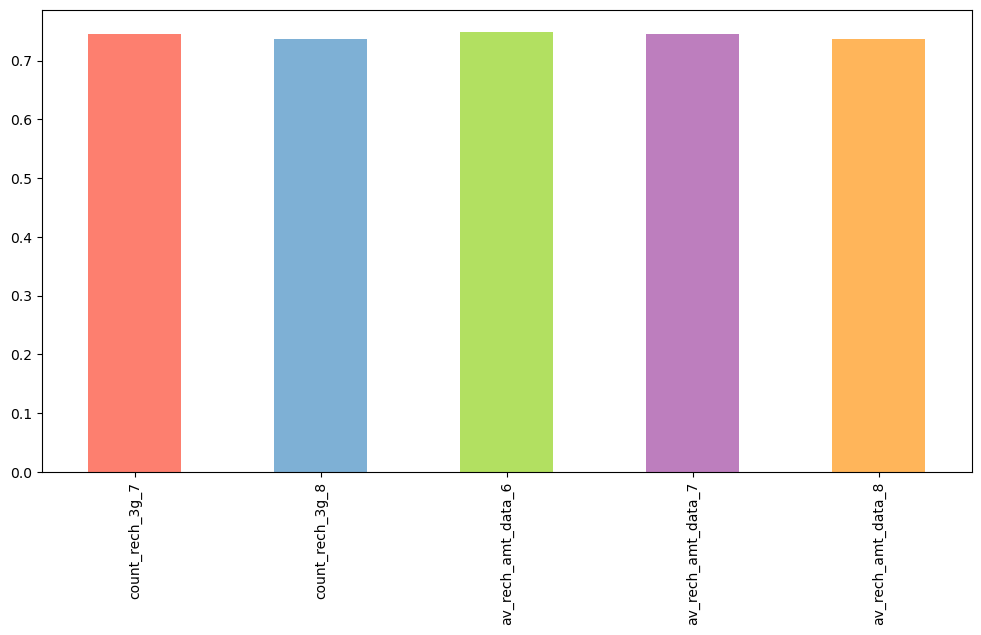

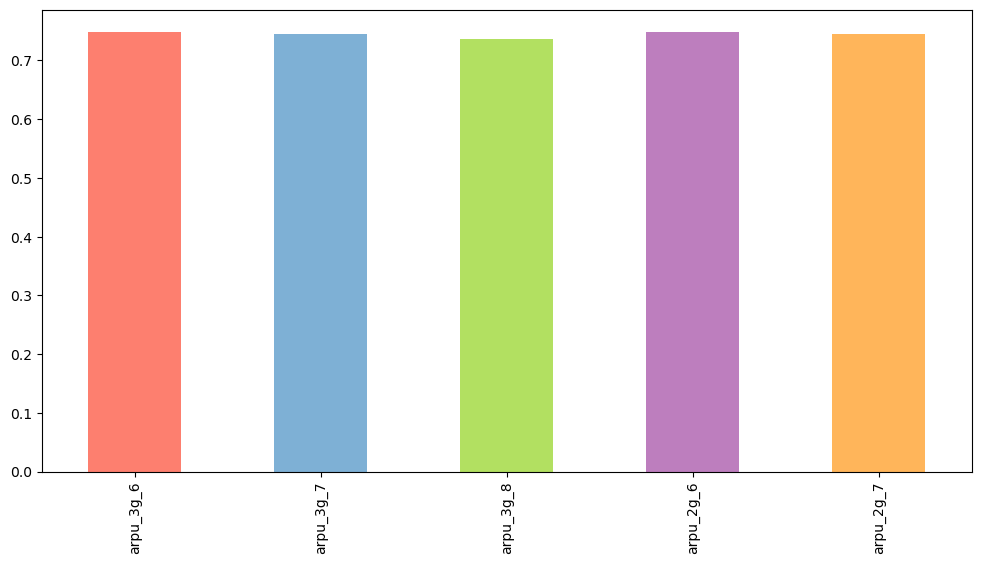

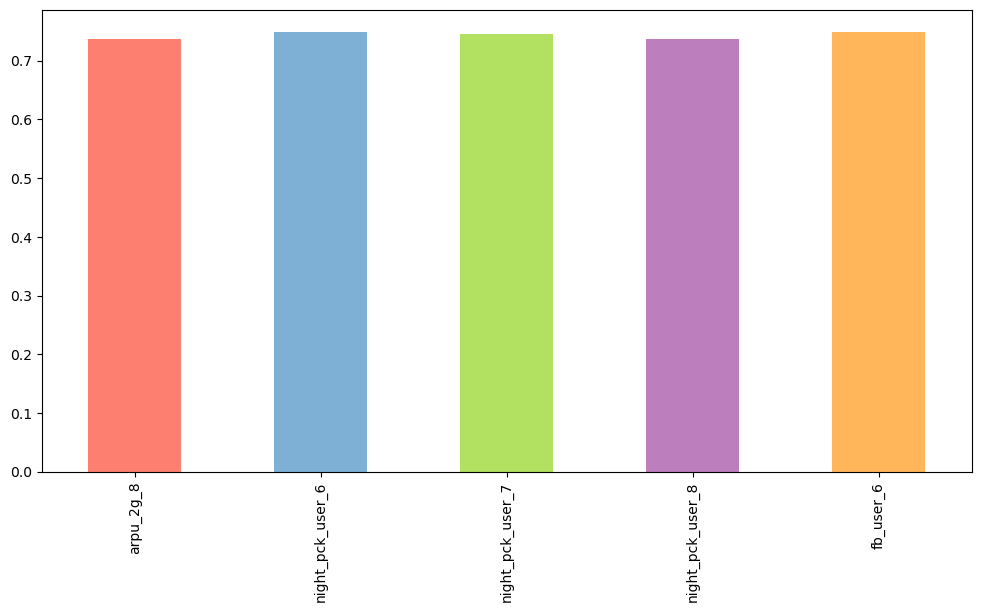

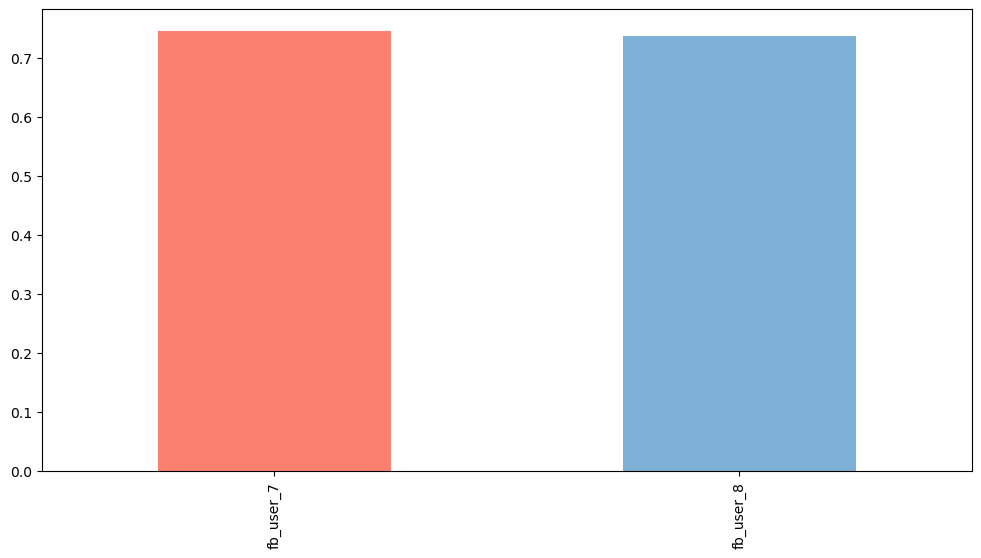

In [13]:
# At this point none of the categorical columns with missing values are in the data set.
# Let us look at the numerical columns with missing values given by the numerical_columns_with_nan variable.
# Let us plot a histogram of the missing values in each of these columns.
# Including 5 numerical columns per plot
for i in range(0,len(numerical_columns_with_nan),5):
    raw_data[numerical_columns_with_nan[i:i+5]].isnull().mean().plot.bar(figsize=(12,6), color=pastel_colors)
    plt.show()

### 2.1.2. Numerical variables with missing values imputation
Since all the columns are either recharge related or usage related, we can impute the missing values with 0.

In [14]:
raw_data[numerical_columns_with_nan] = raw_data[numerical_columns_with_nan].fillna(0)
raw_data[numerical_columns_with_nan].isnull().sum()

loc_og_t2o_mou      0
std_og_t2o_mou      0
loc_ic_t2o_mou      0
onnet_mou_6         0
onnet_mou_7         0
                   ..
night_pck_user_7    0
night_pck_user_8    0
fb_user_6           0
fb_user_7           0
fb_user_8           0
Length: 117, dtype: int64

In [15]:
# Now let us look at the complete data set and see if there are any missing values.
raw_data.isnull().sum()[raw_data.isnull().sum()>0]

Series([], dtype: int64)

Now we no longer have any missing values, so let us split the data set into two parts one containing the categorical variables and the other containing the numerical variables.


In [16]:
fixed_columns = ["id", "circle_id", "churn_probability"]

# Get the list of all non-fixed columns
non_fixed_columns = [col for col in raw_data.columns if col not in fixed_columns]

# Get the numerical and categorical columns
numerical_columns = raw_data[non_fixed_columns].select_dtypes(include=np.number).columns.tolist()
categorical_columns = raw_data[non_fixed_columns].select_dtypes(include=object).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',

In [17]:
# While we do have total incoming mou and total outgoing mou, we do not have total MOU for each month.
# Define the mapping between the month suffixes and month names
month_mapping = {'_6': 'June', '_7': 'July', '_8': 'August'}

# Calculate the total MOU for each month and add new columns to the raw_data data frame
for month_suffix, month_name in month_mapping.items():
    og_columns = [col for col in raw_data.columns if 'og' in col and 'mou' in col and month_suffix in col]
    ic_columns = [col for col in raw_data.columns if 'ic' in col and 'mou' in col and month_suffix in col]
    raw_data[f'total_mou_{month_name}'] = raw_data[og_columns].sum(axis=1) + raw_data[ic_columns].sum(axis=1)

for _, month_name in month_mapping.items():
    print(raw_data[f'total_mou_{month_name}' ].head())

0    267.92
1     10.32
2    541.53
3    498.40
4    323.74
Name: total_mou_June, dtype: float64
0    822.08
1    201.78
2    398.15
3    429.27
4    149.74
Name: total_mou_July, dtype: float64
0    131.85
1    168.21
2    109.41
3    397.08
4    132.18
Name: total_mou_August, dtype: float64


In [18]:
raw_data.describe(include="all")

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69999.0         69999.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69999.0  69999.000000  69999.000000  69999.000000  69999.000000   
mean              0.0    283.134365    278.185912    278.858826    127.887939   
std               0.0    334.213918    344.366927    351.924315    295.115497   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      5.430000   
50%               0.0    197.484000    191.588000    192.234000     30.830000   
75%               0.0    370.791000    365.369500    369.909000    113.100000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7  ...     fb_user_7     fb_user_8           aon  \
count  69999.000000  ...  69999.000000  69999.000000  69999.000000   
mean     128.754731  ...      0.232132      0.234246   1220.639709   
std      306.326345  ...      0.422196      0.423530    952.426321   
min        0.000000  ...      0.000000      0.000000    180.000000   
25%        4.910000  ...      0.000000      0.000000    468.000000   
50%       29.160000  ...      0.000000      0.000000    868.000000   
75%      108.940000  ...      0.000000      0.000000   1813.000000   
max     8157.780000  ...      1.000000      1.000000   4337.000000   

         aug_vbc_3g    jul_vbc_3g   jun_vbc_3g  churn_probability  \
count  69999.000000  69999.000000  69999.00000       69999.000000   
mean      68.108597     65.935830     60.07674           0.101887   
std      269.328659    267.899034    257.22681           0.302502   
min        0.000000      0.000000      0.00000           0.000000   
25%        0.000000      0.000000      0.00000           0.000000   
50%        0.000000      0.000000      0.00000           0.000000   
75%        0.000000      0.000000      0.00000           0.000000   
max    12916.220000   9165.600000  11166.21000           1.000000   

       total_mou_June  total_mou_July  total_mou_August  
count    69999.000000    69999.000000      69999.000000  
mean      1528.219391     1539.361143       1510.778884  
std       1798.686080     1833.538210       1823.092577  
min          0.000000        0.000000          0.000000  
25%        387.395000      382.360000        355.780000  
50%        975.130000      967.030000        952.660000  
75%       2009.115000     2027.910000       2002.440000  
max      36931.510000    31218.540000      42237.240000  

[8 rows x 166 columns]

### There is a possible problem here:
1. Some of the columns have relatively high correlation.
2. Some of the columns have very high skewness.
3. Some of the columns have had imputed values set to 0, but they may not be the correct imputation values.

Let us first look at the correlation between the columns.

### 2.1.3. Columns with high correlation

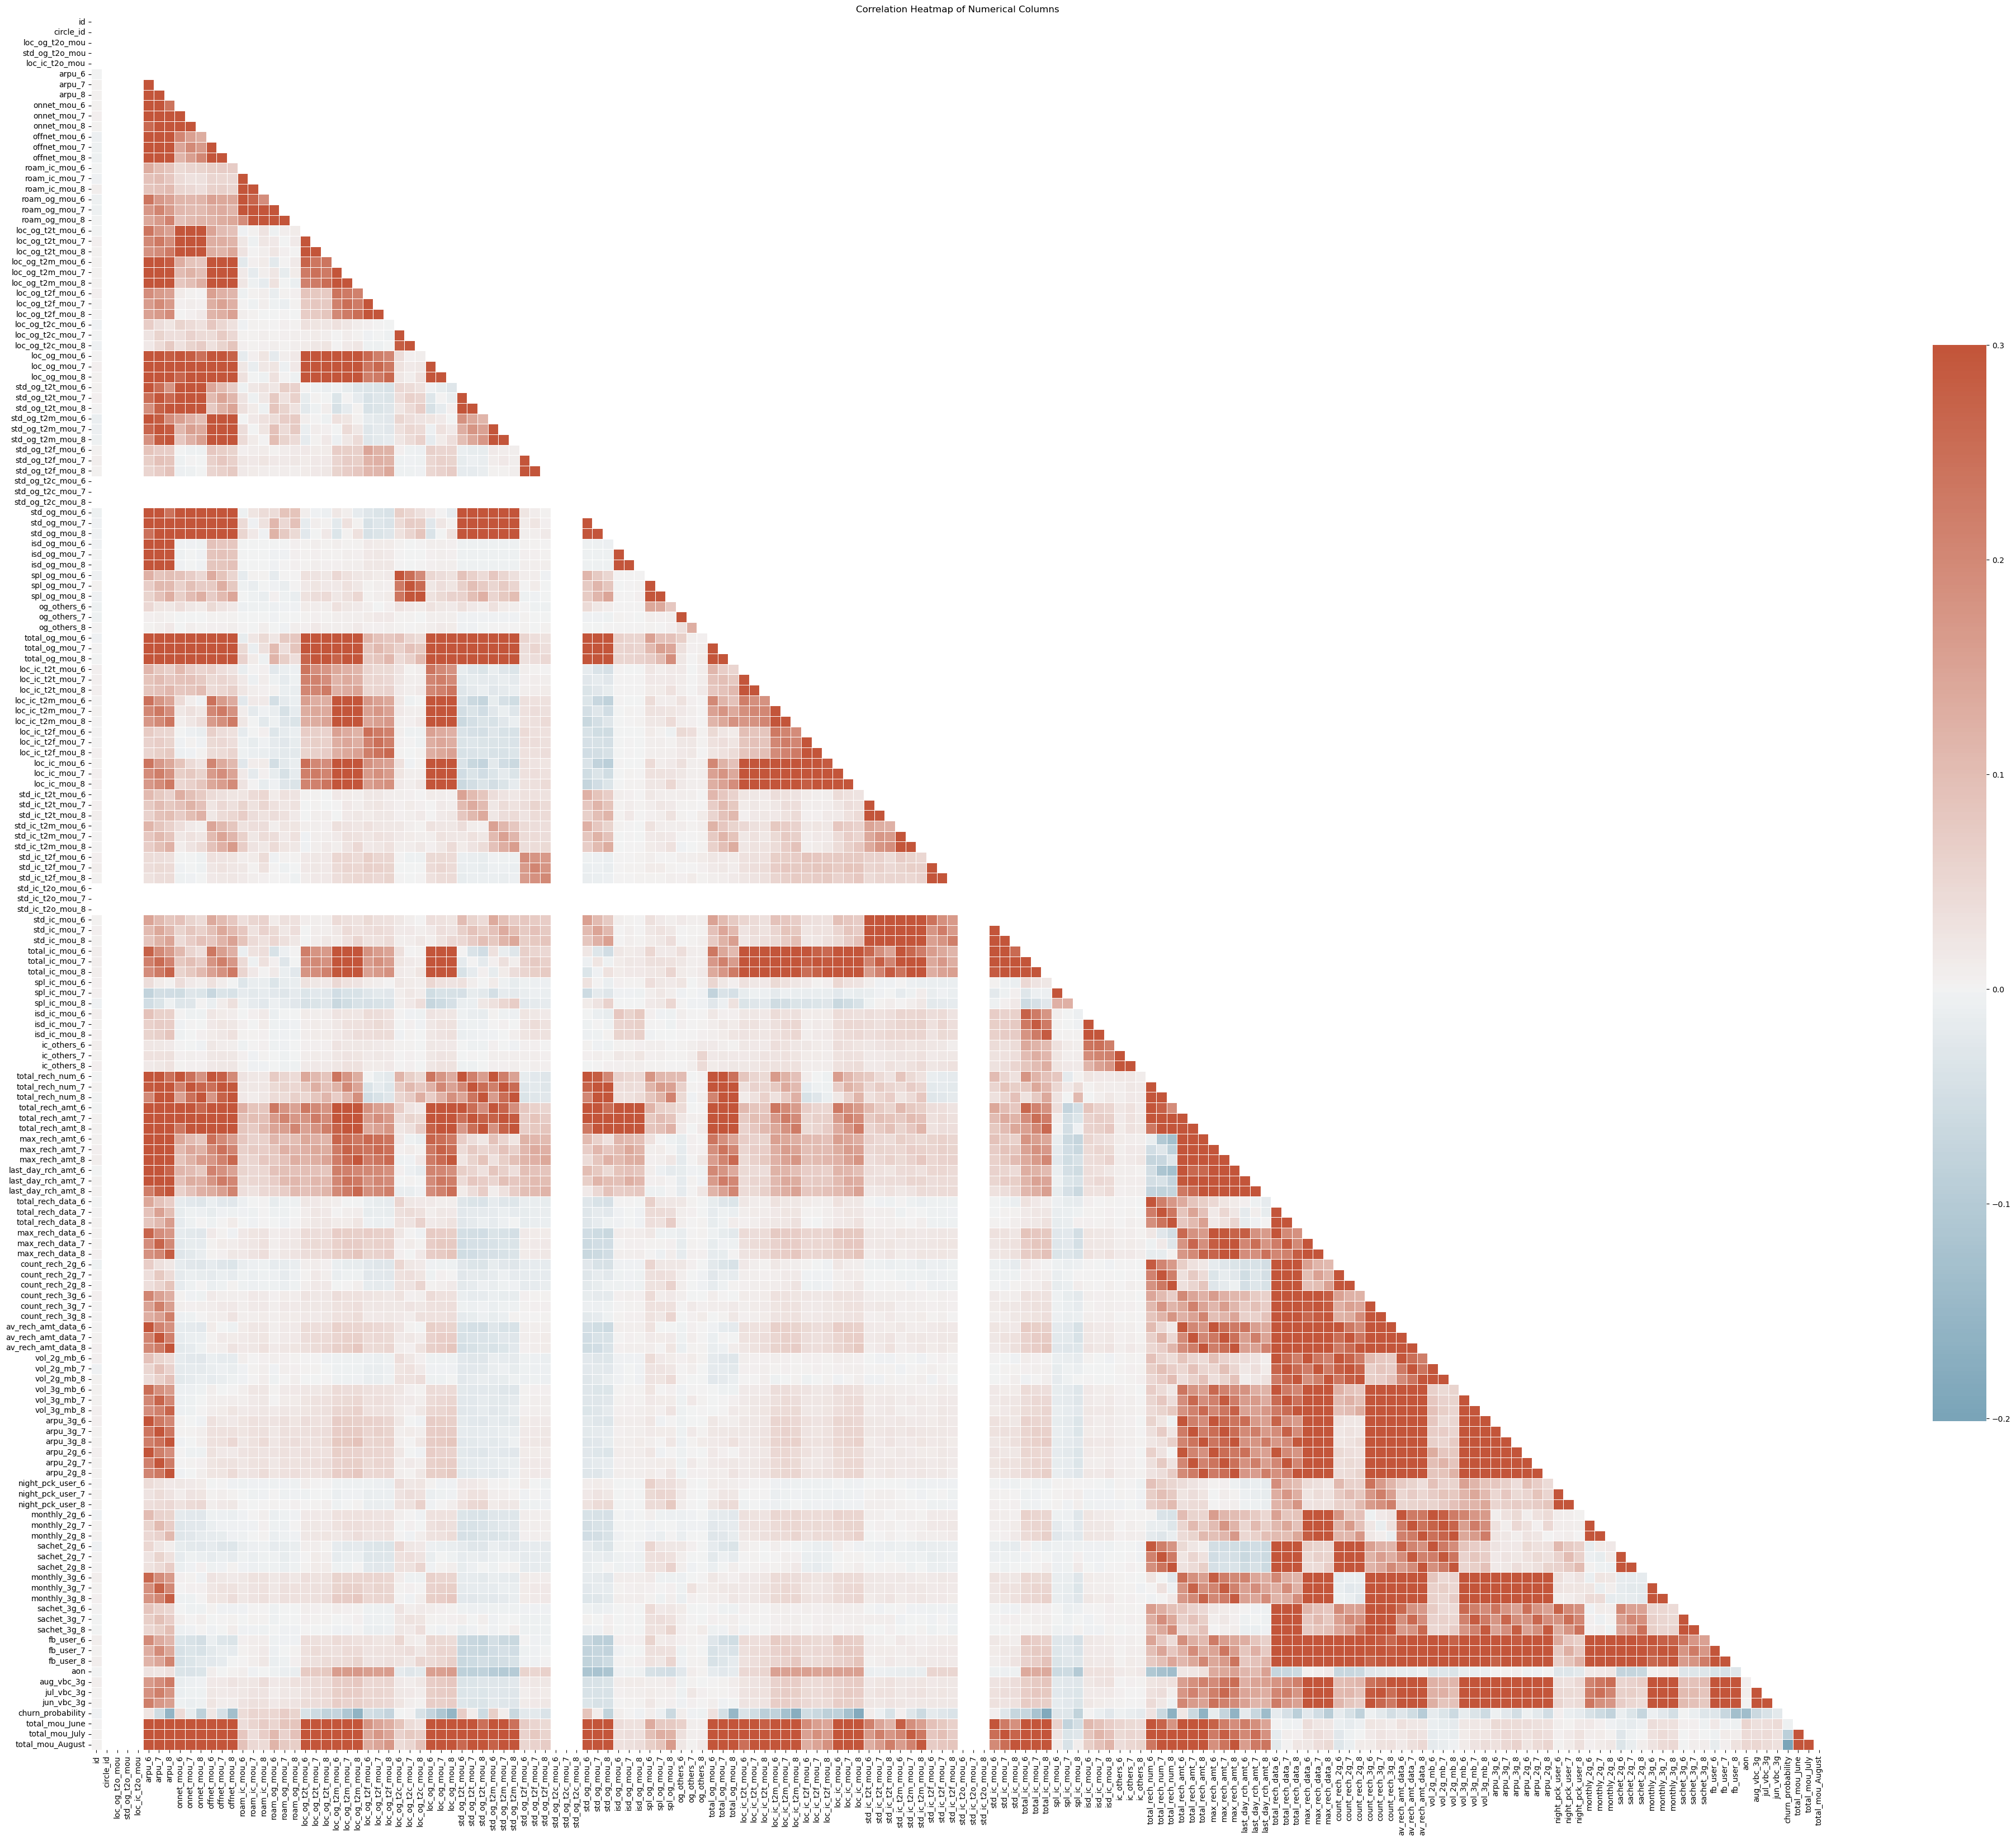

In [19]:
# Let us look at the correlation between the columns and plot it as heat map.
# Calculate correlations
numerical_columns = raw_data.select_dtypes(include=np.number).columns.tolist()
corr = raw_data[numerical_columns].corr()

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

There are too many columns and not all of these columns are really useful. For example - if a customer has recharged within the month then whether they use 3g or 2g is irrelevant.
Similarly if a customer has not recharged within the month then whether they use 3g or 2g is irrelevant. So perhaps we can drop 2g/3g related columns. Let us look at the correlation between the 2g/3g related columns and the churn probability.


In [20]:
# Calculate the correlation with 'churn_probability' for all the columns and look at the top values.
correlations = raw_data[numerical_columns].apply(lambda x: x.corr(raw_data['churn_probability']))

# Sort in ascending order
correlations_asc = correlations.sort_values()

# Sort in descending order
correlations_desc = correlations.sort_values(ascending=False)

print("Correlations sorted in ascending order:\n", correlations_asc)
print("\nCorrelations sorted in descending order:\n", correlations_desc)


Correlations sorted in ascending order:
 total_mou_August   -0.201316
total_ic_mou_8     -0.187566
loc_ic_mou_8       -0.182085
loc_ic_t2m_mou_8   -0.176718
total_rech_num_8   -0.167043
                      ...   
std_og_t2c_mou_7         NaN
std_og_t2c_mou_8         NaN
std_ic_t2o_mou_6         NaN
std_ic_t2o_mou_7         NaN
std_ic_t2o_mou_8         NaN
Length: 166, dtype: float64

Correlations sorted in descending order:
 churn_probability    1.000000
std_og_mou_6         0.087780
std_og_t2t_mou_6     0.069426
roam_og_mou_7        0.068077
std_og_t2m_mou_6     0.066194
                       ...   
std_og_t2c_mou_7          NaN
std_og_t2c_mou_8          NaN
std_ic_t2o_mou_6          NaN
std_ic_t2o_mou_7          NaN
std_ic_t2o_mou_8          NaN
Length: 166, dtype: float64


In [21]:
# Let us only look at correlation between totals columns and churn probability
total_columns = [col for col in raw_data.columns if 'total' in col]
correlations = raw_data[total_columns].apply(lambda x: x.corr(raw_data['churn_probability']))
print(correlations.sort_values(ascending=False))

total_og_mou_6       0.033225
total_rech_num_6     0.025966
total_rech_amt_6     0.018869
total_mou_June      -0.005421
total_rech_data_6   -0.017259
total_rech_data_7   -0.045962
total_og_mou_7      -0.047588
total_rech_num_7    -0.062956
total_rech_amt_7    -0.063978
total_ic_mou_6      -0.070951
total_rech_data_8   -0.090536
total_mou_July      -0.091337
total_ic_mou_7      -0.120197
total_og_mou_8      -0.149325
total_rech_amt_8    -0.160455
total_rech_num_8    -0.167043
total_ic_mou_8      -0.187566
total_mou_August    -0.201316
dtype: float64


Let us look at correlation between all the numerical columns.


In [22]:
# Calculate the correlation matrix
corr_matrix = raw_data.corr()

# Create a DataFrame to store the highly correlated pairs
highly_correlated_pairs = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

# Define your threshold
threshold = 0.8

# Loop through the columns of the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs = highly_correlated_pairs.append({'Feature 1': corr_matrix.columns[i],
                                                                      'Feature 2': corr_matrix.columns[j],
                                                                      'Correlation': corr_matrix.iloc[i, j]},
                                                                     ignore_index=True)

print(highly_correlated_pairs)


      Feature 1         Feature 2  Correlation
0        arpu_6  total_rech_amt_6     0.952776
1        arpu_7  total_rech_amt_7     0.955298
2        arpu_8  total_rech_amt_8     0.958333
3   onnet_mou_6  std_og_t2t_mou_6     0.855785
4   onnet_mou_7  std_og_t2t_mou_7     0.862664
..          ...               ...          ...
59    arpu_3g_8         arpu_2g_8     0.935173
60    arpu_3g_8      monthly_3g_8     0.836255
61    arpu_2g_6      monthly_3g_6     0.849265
62    arpu_2g_7      monthly_3g_7     0.851765
63    arpu_2g_8      monthly_3g_8     0.848269

[64 rows x 3 columns]


There are 64 pairs with correlation greater than 0.8. This sort of suggests that including all of these columns
doesn't make any sense. So let us drop some of these columns.


In [23]:
# Create a copy of the original dataframe
raw_data_copy = raw_data.copy()

# Drop the second feature from each correlated pair
for index, row in highly_correlated_pairs.iterrows():
    if row['Feature 2'] in raw_data_copy.columns:
        raw_data_copy = raw_data_copy.drop(columns=row['Feature 2'])

# raw_data_copy now holds the dataframe with the correlated features removed

print(raw_data_copy.shape)
print(raw_data.shape)
raw_data_copy.head()

(69999, 114)
(69999, 166)


id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou   arpu_6  \
0   0        109             0.0             0.0             0.0   31.277   
1   1        109             0.0             0.0             0.0    0.000   
2   2        109             0.0             0.0             0.0   60.806   
3   3        109             0.0             0.0             0.0  156.362   
4   4        109             0.0             0.0             0.0  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  ...  monthly_2g_7  \
0   87.009    7.527        48.58       124.38  ...             0   
1  122.787   42.953         0.00         0.00  ...             0   
2  103.176    0.000         0.53        15.93  ...             0   
3  205.260  111.095         7.26        16.01  ...             0   
4  128.191  101.565        21.28         4.83  ...             0   

   monthly_2g_8  fb_user_6  fb_user_7  fb_user_8   aon  aug_vbc_3g  \
0             0        0.0        0.0        0.0  1958         0.0   
1             0        0.0        1.0        0.0   710         0.0   
2             0        0.0        0.0        0.0   882         0.0   
3             0        0.0        0.0        0.0   982         0.0   
4             0        1.0        1.0        1.0   647         0.0   

   jul_vbc_3g  jun_vbc_3g  churn_probability  
0         0.0         0.0                  0  
1         0.0         0.0                  0  
2         0.0         0.0                  0  
3         0.0         0.0                  0  
4         0.0         0.0                  0  

[5 rows x 114 columns]

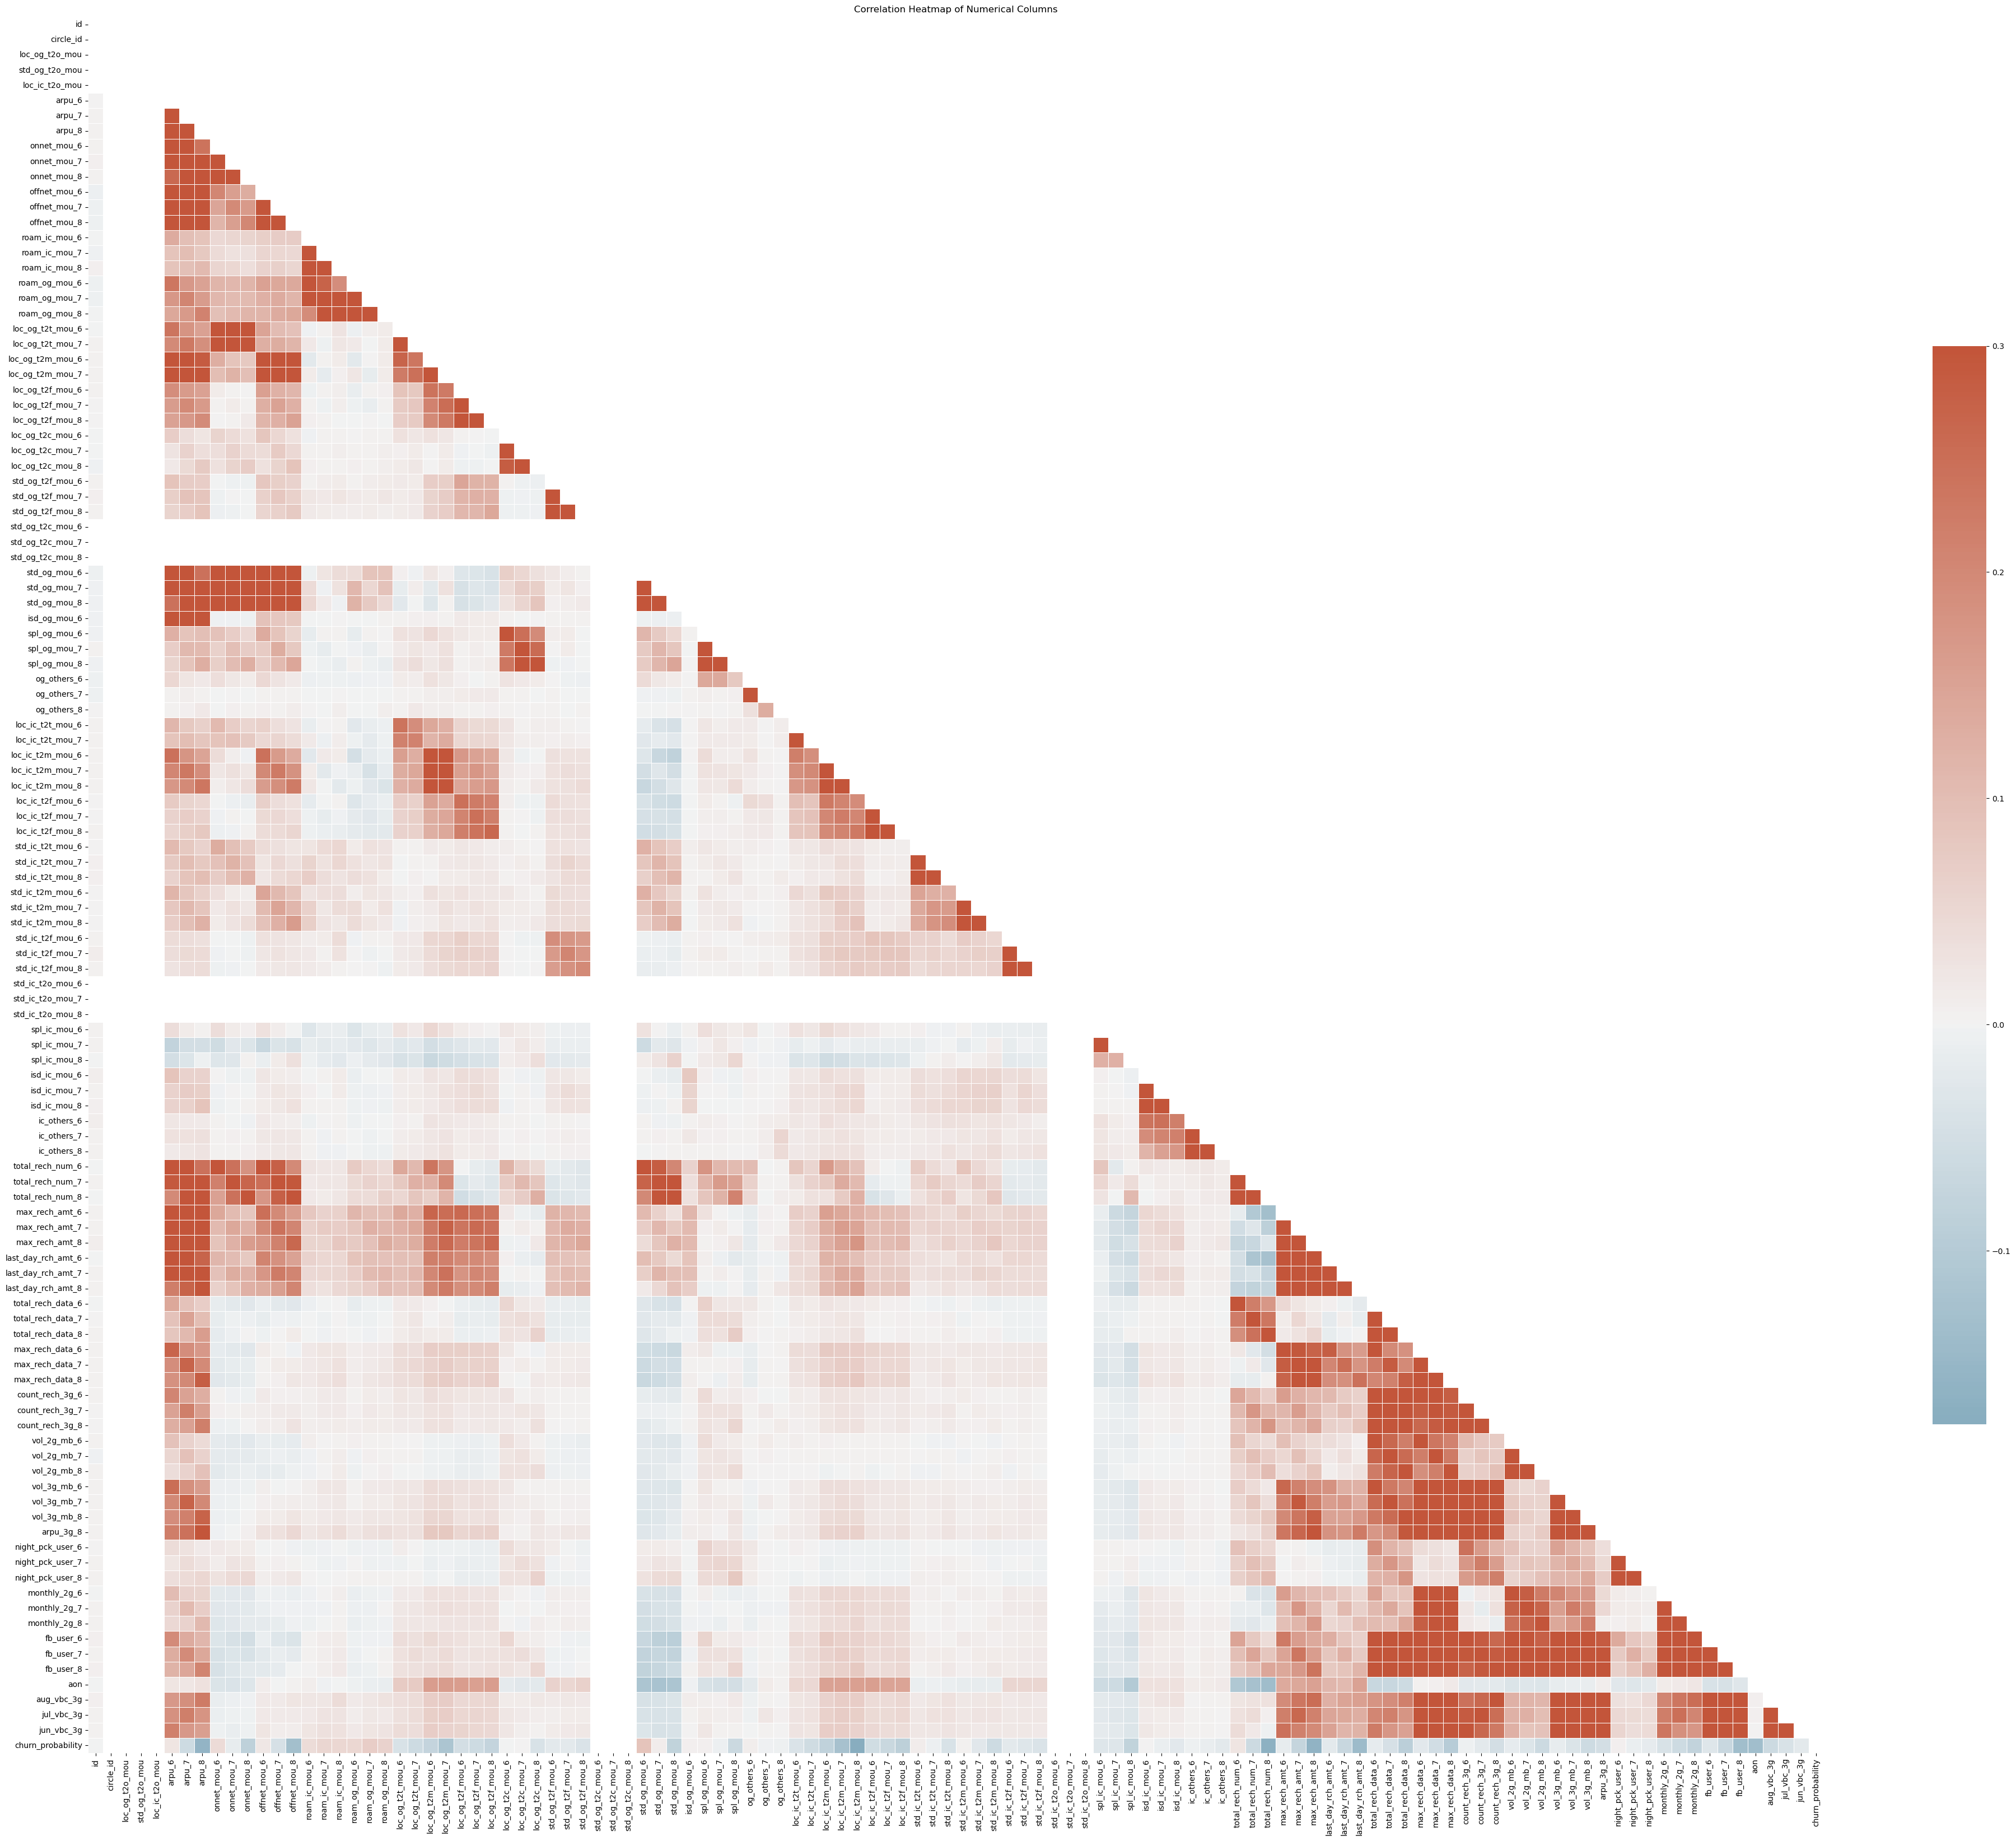

In [24]:
corr_matrix = raw_data_copy.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

### 2.1.4. Columns with high skew

<AxesSubplot:>

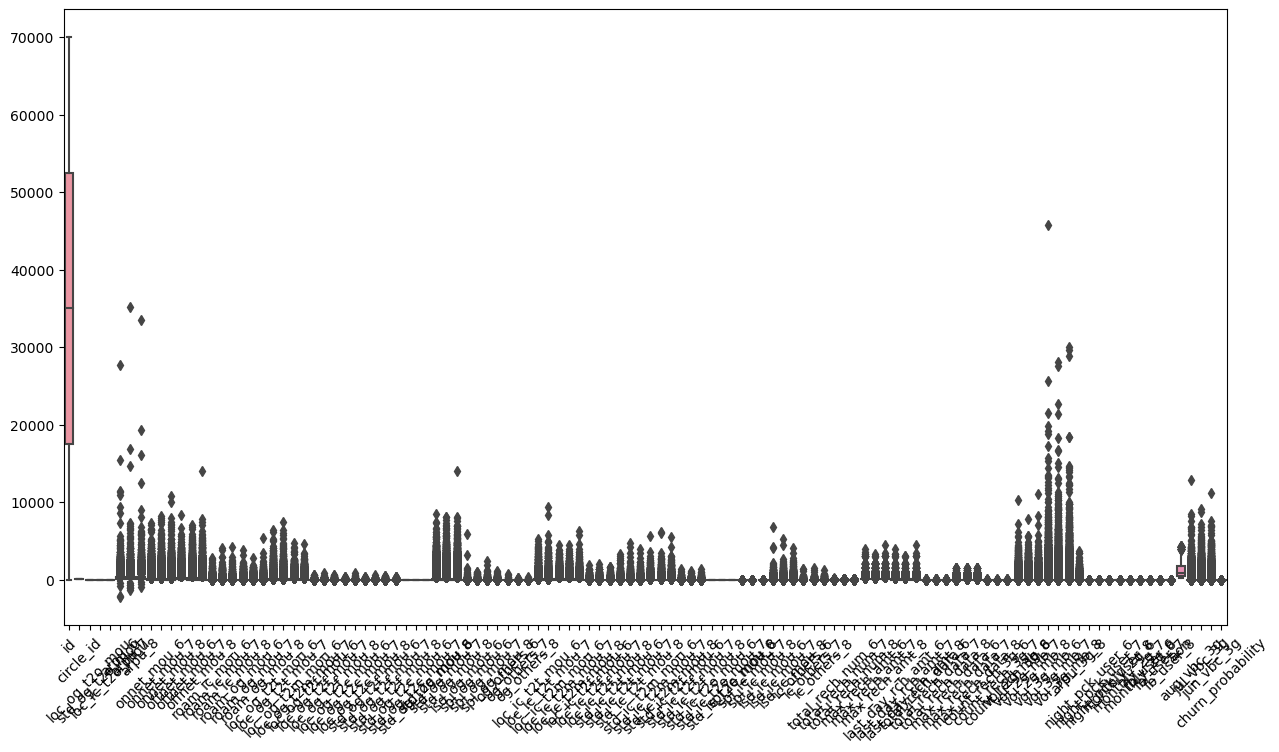

In [25]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = raw_data_copy)

In [26]:
tmp_df =pd.DataFrame(raw_data_copy.skew().sort_values(ascending = False))
tmp_df.columns = ['Skewness']

In [27]:
# let us filter those columns which have lot of skewness.  
# Let us select 40 as a threshold to eliminate maximum skewness.

skew = tmp_df['Skewness'].loc[lambda x: x>=40].index
skew

Index(['isd_og_mou_6', 'og_others_8', 'og_others_7', 'og_others_6',
       'ic_others_6', 'ic_others_7', 'ic_others_8', 'spl_og_mou_7',
       'loc_og_t2c_mou_7'],
      dtype='object')

In [28]:
tmp_df

Skewness
isd_og_mou_6      144.475199
og_others_8       133.710455
og_others_7       129.915125
og_others_6       120.384715
ic_others_6        68.324909
...                      ...
std_og_t2c_mou_6    0.000000
loc_ic_t2o_mou      0.000000
std_og_t2o_mou      0.000000
loc_og_t2o_mou      0.000000
id                  0.000000

[114 rows x 1 columns]

# TODO: 
## Created a new variable here telco_data so that below calculations do not get misleaded, please free to change any variable. Will use telco_data for model building

In [29]:
telco_train_data = raw_data_copy

0    62867
1     7132
Name: churn_probability, dtype: int64
Churn_percentage : 10.19%


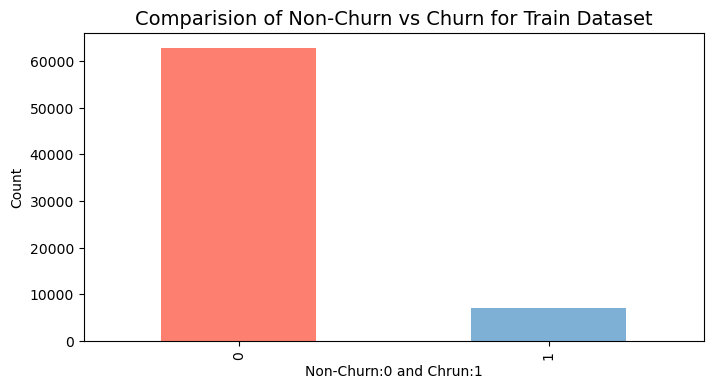

In [30]:
# Let's start by checking the target variable distribution, only in the Train dataset

print(telco_train_data['churn_probability'].value_counts())
print('Churn_percentage : {0}%'.format(round(((sum(telco_train_data['churn_probability'])/len(telco_train_data['churn_probability']))*100),2)))
plt.figure(figsize=(8,4))
telco_train_data['churn_probability'].value_counts().plot(kind = 'bar', color=pastel_colors)
plt.ylabel('Count')
plt.xlabel('Non-Churn:0 and Chrun:1')
plt.title('Comparision of Non-Churn vs Churn for Train Dataset',fontsize=14)

plt.show()

As we can see the churn percentage is very low. Thus, this dataset is an imabalanced dataset.

ValueError: Could not interpret input 'loc_og_t2t_mou_8'

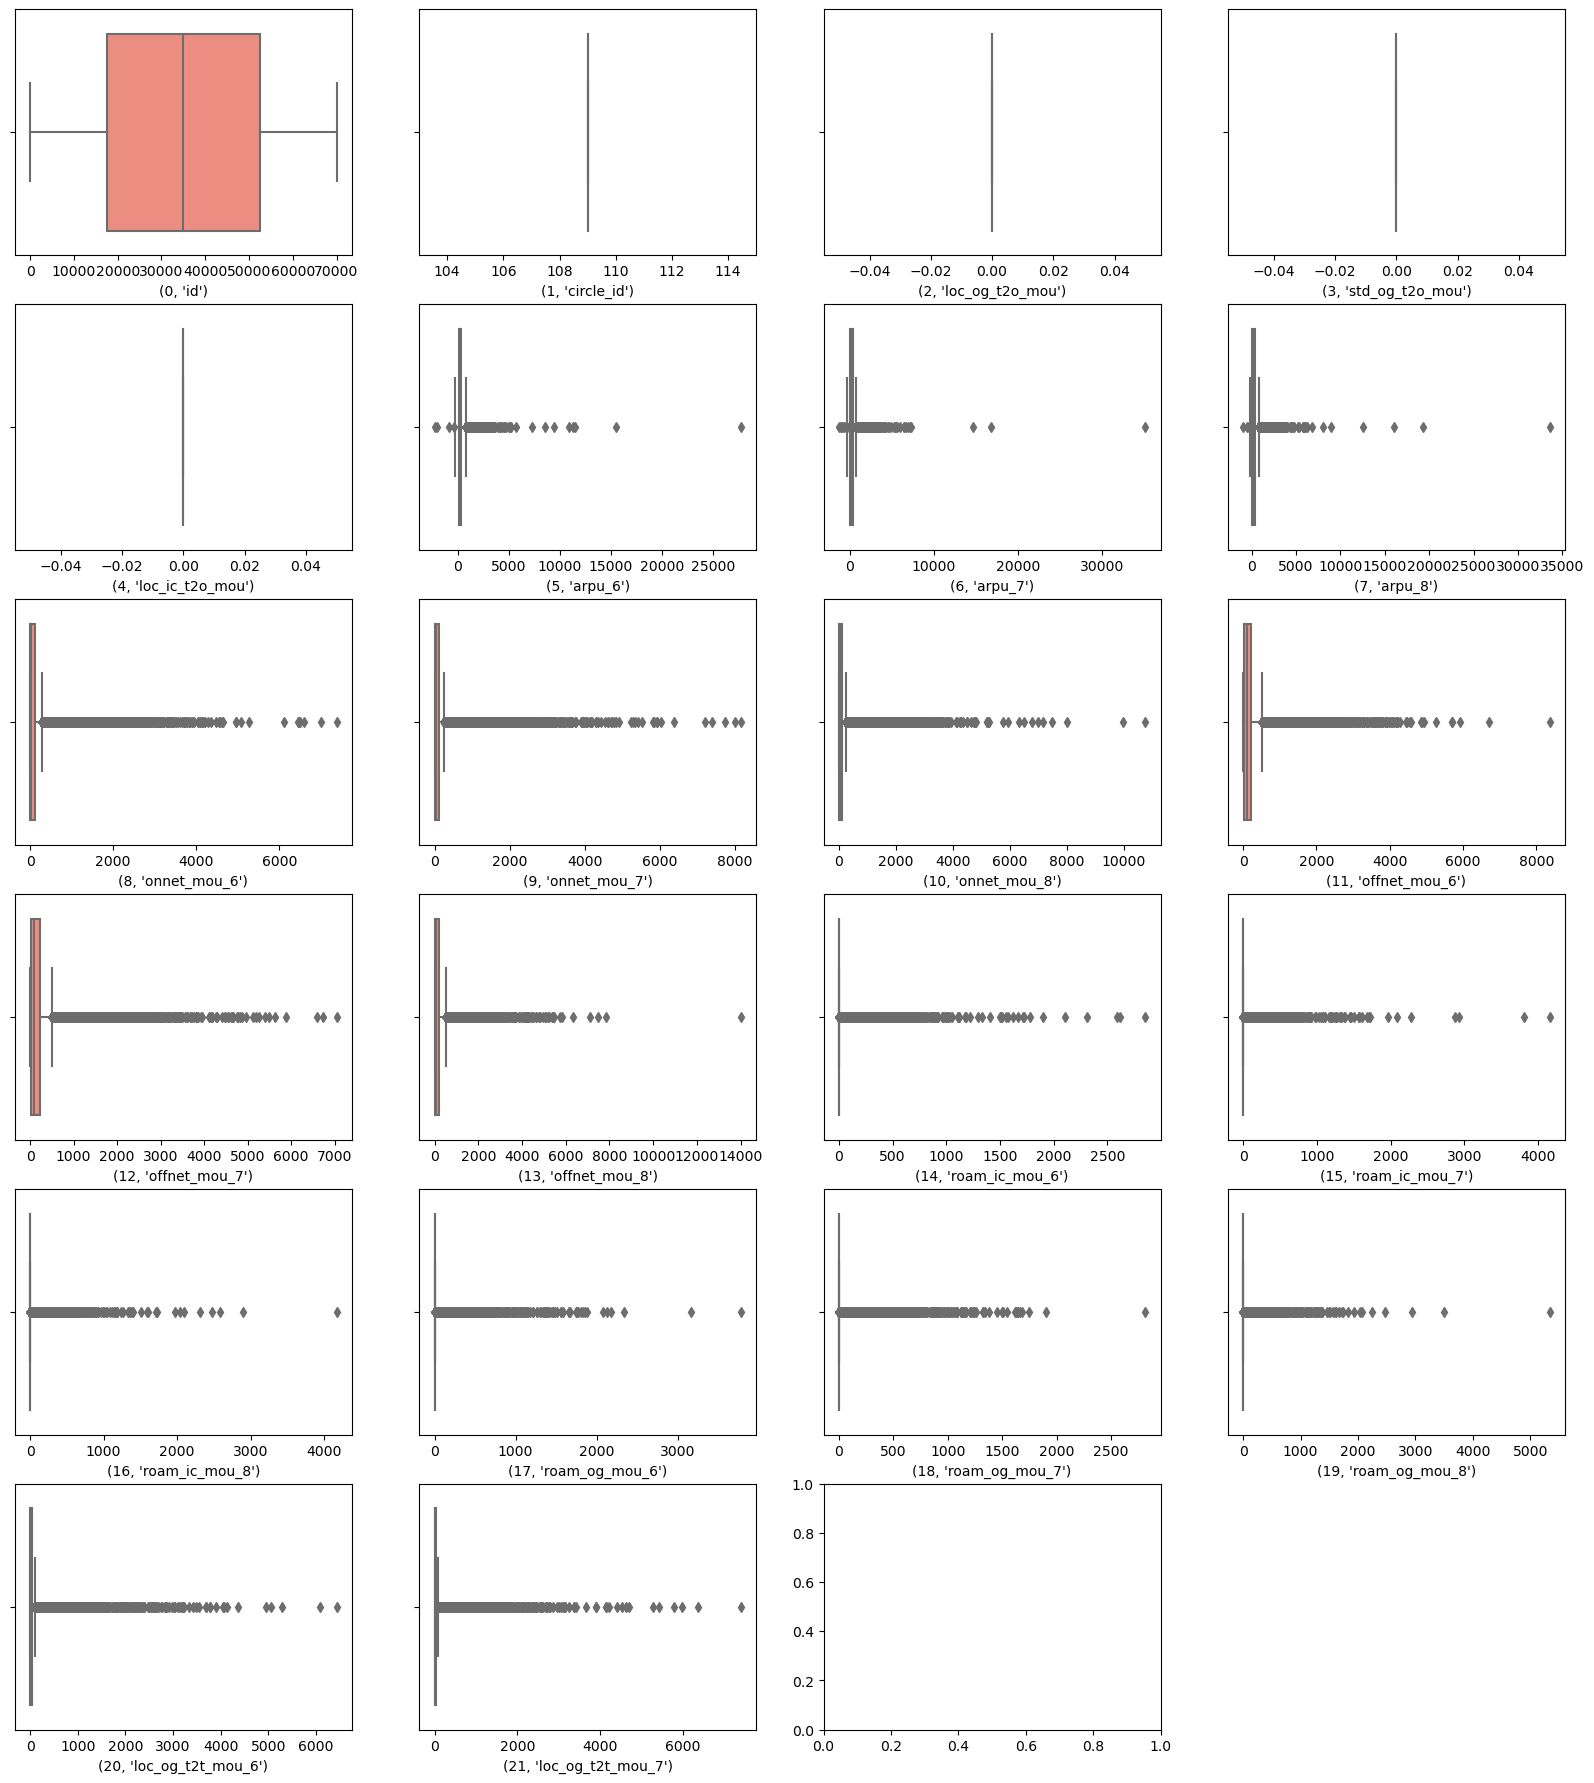

In [31]:
plt.figure(figsize=(20,30))
for i in enumerate(numerical_columns):
    plt.subplot(8,4,i[0]+1)
    sns.boxplot(x=i[1], data=telco_train_data, palette=pastel_colors)
    plt.xlabel(i)

# 3. Feature Engineering

At this point we only have numerical variables left in our dataset and all categorical variables have been eliminated

### 3.1.1 Correlation analysis

<AxesSubplot:>

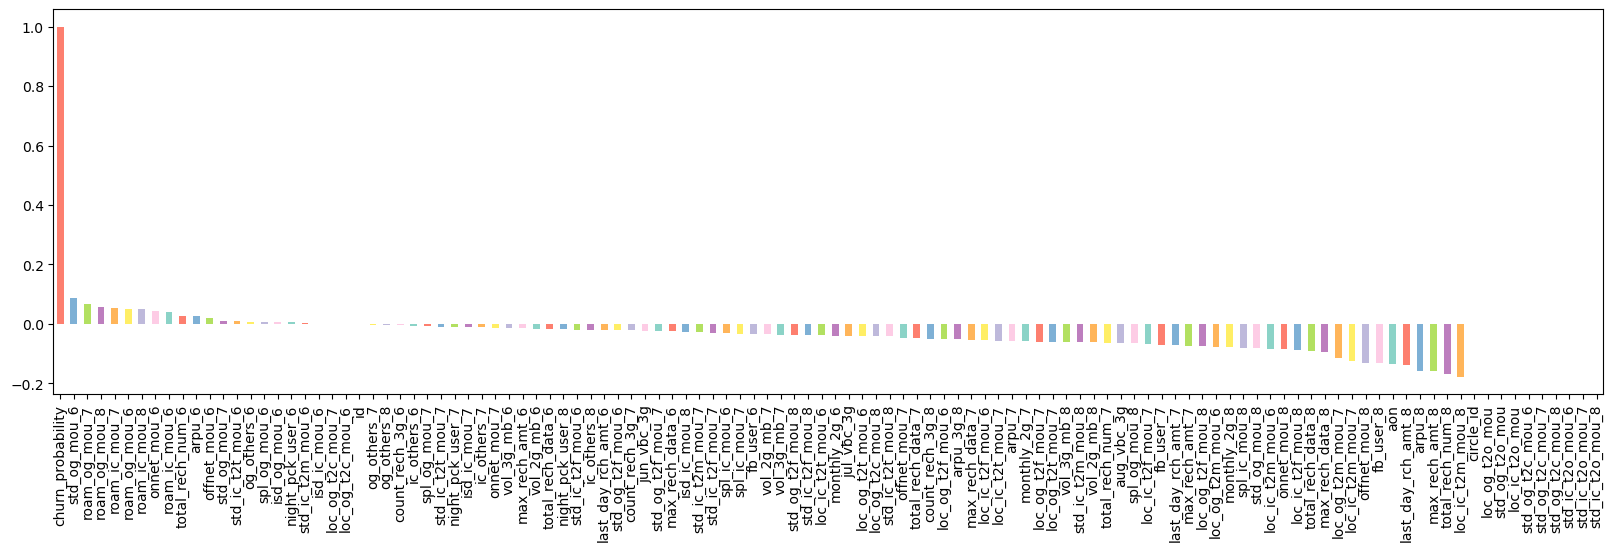

In [32]:
# Show correlation plot for correlation of churn with each of the remaining features.
plt.figure(figsize=(16,10))
telco_train_data.corr()['churn_probability'].sort_values(ascending=False).plot(kind='bar', figsize=(20,5), color=pastel_colors)

### 3.1.2 Standard Scaling
Since, Standard scaling is less affected by outliers, it is commonly used in algorithms that assume Gaussian-distributed data or rely on distance measures (e.g., k-means clustering) or regularization techniques (e.g., logistic regression, linear regression).

# 4. Train/Test Split

### 4.1.1 Data Preparation

In [35]:
# TODO: Temporary assignment to new datasets for train and test
churn_train_df = telco_train_data.copy()
churn_test_df = test_data[churn_train_df.columns[:-1]].copy()


In [36]:
# Storing ID column from Train and Test datasets before dropping for Model Building
churn_train_id = churn_train_df['id']
churn_test_id = churn_test_df['id']

# Storing target variable values before dropping for Model Building
y_churn_train = churn_train_df['churn_probability']

# Dropping ID and churn probability columns from Train and Test datasets
churn_train_df.drop(['id', 'churn_probability'], axis=1, inplace=True)
churn_test_df.drop(['id'], axis=1, inplace=True)

In [37]:
# Scaling numerical values for the dataset
scaler = StandardScaler()

churn_train_df[churn_train_df.columns] = scaler.fit_transform(churn_train_df[churn_train_df.columns])
churn_test_df[churn_test_df.columns] = scaler.transform(churn_test_df[churn_test_df.columns])

# Displaying descriptive statistics of the train dataset
churn_train_df.describe()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    69999.0         69999.0         69999.0         69999.0   
mean         0.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min          0.0             0.0             0.0             0.0   
25%          0.0             0.0             0.0             0.0   
50%          0.0             0.0             0.0             0.0   
75%          0.0             0.0             0.0             0.0   
max          0.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  6.999900e+04  6.999900e+04  6.999900e+04  6.999900e+04  6.999900e+04   
mean  -1.064957e-17 -7.899508e-17  1.482129e-16 -1.515809e-16  4.452748e-16   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -7.605493e+00 -4.553028e+00 -3.479940e+00 -4.333519e-01 -4.203218e-01   
25%   -5.671658e-01 -5.560153e-01 -5.534293e-01 -4.149522e-01 -4.042931e-01   
50%   -2.562759e-01 -2.514717e-01 -2.461479e-01 -3.288835e-01 -3.251286e-01   
75%    2.622789e-01  2.531724e-01  2.587227e-01 -5.010934e-02 -6.468550e-02   
max    8.212749e+01  1.012522e+02  9.452317e+01  2.456284e+01  2.621088e+01   

        onnet_mou_8  ...  monthly_2g_6  monthly_2g_7  monthly_2g_8  \
count  6.999900e+04  ...  6.999900e+04  6.999900e+04  6.999900e+04   
mean   3.495064e-16  ...  1.140831e-15  3.458053e-15  7.606088e-16   
std    1.000007e+00  ...  1.000007e+00  1.000007e+00  1.000007e+00   
min   -4.129456e-01  ... -2.690276e-01 -2.736263e-01 -2.704401e-01   
25%   -3.994697e-01  ... -2.690276e-01 -2.736263e-01 -2.704401e-01   
50%   -3.216634e-01  ... -2.690276e-01 -2.736263e-01 -2.704401e-01   
75%   -6.447330e-02  ... -2.690276e-01 -2.736263e-01 -2.704401e-01   
max    3.484269e+01  ...  1.330334e+01  1.613059e+01  1.643789e+01   

          fb_user_6     fb_user_7     fb_user_8           aon    aug_vbc_3g  \
count  6.999900e+04  6.999900e+04  6.999900e+04  6.999900e+04  6.999900e+04   
mean  -5.054010e-15  1.574657e-15 -1.779795e-15 -1.442898e-16 -1.368249e-15   
std    1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00  1.000007e+00   
min   -5.464967e-01 -5.498245e-01 -5.530848e-01 -1.092627e+00 -2.528847e-01   
25%   -5.464967e-01 -5.498245e-01 -5.530848e-01 -7.902397e-01 -2.528847e-01   
50%   -5.464967e-01 -5.498245e-01 -5.530848e-01 -3.702567e-01 -2.528847e-01   
75%   -5.464967e-01 -5.498245e-01 -5.530848e-01  6.219531e-01 -2.528847e-01   
max    1.829837e+00  1.818762e+00  1.808041e+00  3.272046e+00  4.770455e+01   

         jul_vbc_3g    jun_vbc_3g  
count  6.999900e+04  6.999900e+04  
mean  -3.044771e-15  5.331958e-16  
std    1.000007e+00  1.000007e+00  
min   -2.461237e-01 -2.335572e-01  
25%   -2.461237e-01 -2.335572e-01  
50%   -2.461237e-01 -2.335572e-01  
75%   -2.461237e-01 -2.335572e-01  
max    3.396701e+01  4.317673e+01  

[8 rows x 112 columns]

In [38]:
# Displaying descriptive statistics of the test dataset
churn_test_df.describe()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    30000.0         29684.0         29684.0         29684.0   
mean         0.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min          0.0             0.0             0.0             0.0   
25%          0.0             0.0             0.0             0.0   
50%          0.0             0.0             0.0             0.0   
75%          0.0             0.0             0.0             0.0   
max          0.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  30000.000000  30000.000000  30000.000000  28831.000000  28828.000000   
mean      -0.001466      0.003395      0.002803      0.009291      0.014344   
std        0.941201      0.938556      0.927584      0.984969      0.988893   
min       -1.400841     -6.656409     -1.209694     -0.433352     -0.420322   
25%       -0.569181     -0.553719     -0.553186     -0.408683     -0.398580   
50%       -0.254051     -0.250929     -0.247692     -0.315567     -0.314062   
75%        0.265804      0.252828      0.252743     -0.036318     -0.044217   
max       31.931668     37.593696     37.585444     23.097807     23.773036   

        onnet_mou_8  ...  monthly_2g_6  monthly_2g_7  monthly_2g_8  \
count  28325.000000  ...  30000.000000  30000.000000  30000.000000   
mean       0.023502  ...      0.004003     -0.001972      0.000792   
std        0.990044  ...      1.003851      0.995565      1.003511   
min       -0.412946  ...     -0.269028     -0.273626     -0.270440   
25%       -0.391502  ...     -0.269028     -0.273626     -0.270440   
50%       -0.304548  ...     -0.269028     -0.273626     -0.270440   
75%       -0.026931  ...     -0.269028     -0.273626     -0.270440   
max       21.633108  ...     13.303340     16.130593     16.437887   

         fb_user_6    fb_user_7    fb_user_8           aon    aug_vbc_3g  \
count  7585.000000  7706.000000  7922.000000  30000.000000  30000.000000   
mean      1.615857     1.598378     1.552913     -0.002747      0.000763   
std       0.680265     0.688106     0.733053      1.008075      0.978219   
min      -0.546497    -0.549824    -0.553085     -1.092627     -0.252885   
25%       1.829837     1.818762     1.808041     -0.792340     -0.252885   
50%       1.829837     1.818762     1.808041     -0.386006     -0.252885   
75%       1.829837     1.818762     1.808041      0.603054     -0.252885   
max       1.829837     1.818762     1.808041      3.125052     22.226837   

         jul_vbc_3g    jun_vbc_3g  
count  30000.000000  30000.000000  
mean       0.011238     -0.000720  
std        1.040509      0.956743  
min       -0.246124     -0.233557  
25%       -0.246124     -0.233557  
50%       -0.246124     -0.233557  
75%       -0.246124     -0.233557  
max       29.596825     25.481403  

[8 rows x 112 columns]

In [39]:
# Nomination of X_train and y_train
X_train = churn_train_df.copy()
y_train = y_churn_train.copy()
X_test = churn_test_df.copy()

# 5. Model Evaluation Metrics Definition

### 5.1.1 Feature Elimination - PCA

In [40]:
# Starting PCA
pca = PCA(random_state=100)
pca.fit(X_train)


PCA(random_state=100)

In [50]:
pca.components_

array([[-2.20327778e-19,  0.00000000e+00,  3.33066907e-16, ...,
         1.69514391e-01,  1.71619144e-01,  1.61885145e-01],
       [-1.05389009e-19, -5.55111512e-17,  1.38777878e-16, ...,
        -1.01180880e-01, -1.04411206e-01, -9.89758547e-02],
       [-1.89407289e-20, -6.93889390e-18, -1.43982049e-16, ...,
         1.00010471e-02,  9.03372170e-03,  1.14597419e-02],
       ...,
       [ 0.00000000e+00, -1.20777556e-01, -6.81172241e-02, ...,
        -9.88792381e-17,  7.97972799e-17, -4.16333634e-17],
       [ 9.99998243e-01, -9.51101792e-04,  1.61444887e-03, ...,
         0.00000000e+00, -2.43945489e-19,  2.71050543e-20],
       [-0.00000000e+00, -4.13202251e-02, -2.13987416e-02, ...,
         2.44596010e-16, -4.16333634e-17,  2.42861287e-16]])

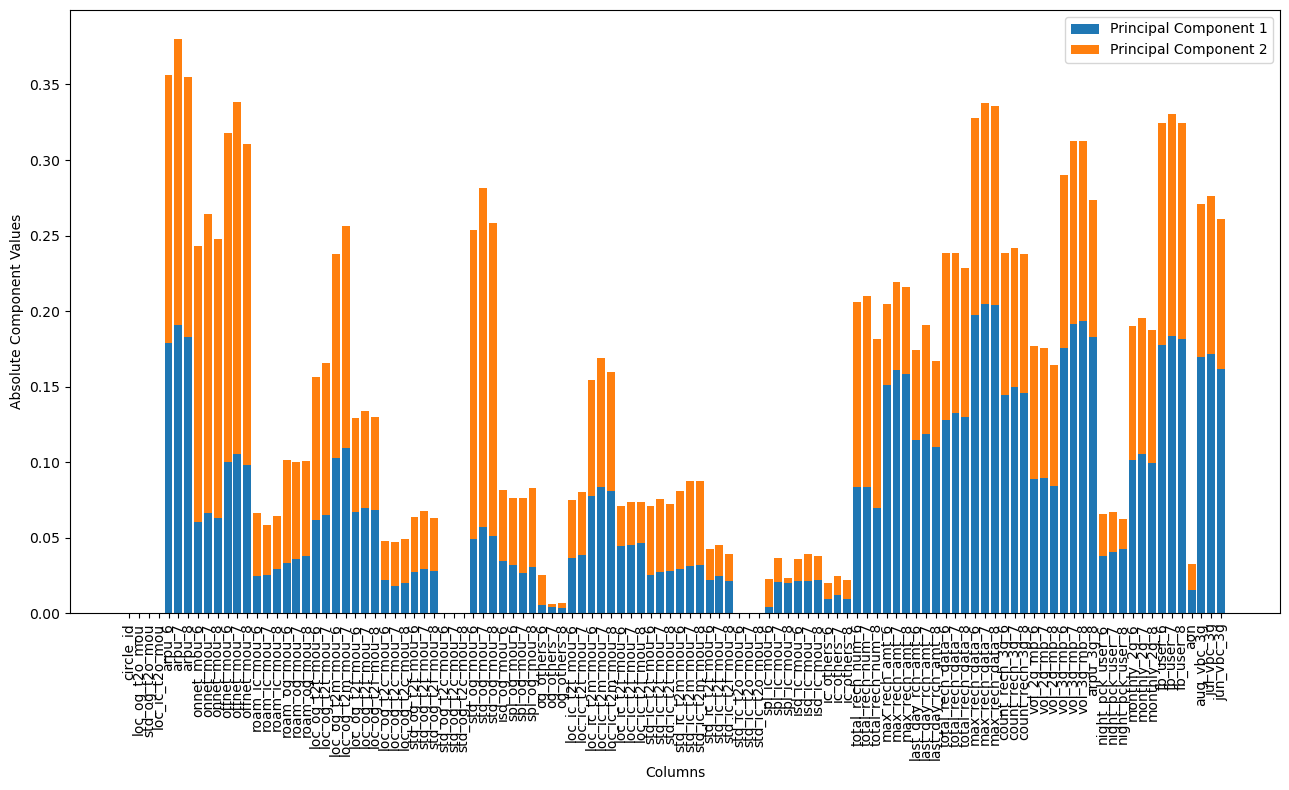

In [47]:
# Plotting PCA Components with absolute values
fig, ax = plt.subplots(figsize=(13, 8))
abs_components = np.abs(pca.components_[:2])
columns = churn_train_df.columns
x = np.arange(len(columns))
ax.bar(x, abs_components[0], label='Principal Component 1')
ax.bar(x, abs_components[1], bottom=abs_components[0], label='Principal Component 2')
ax.set_xticks(x)
ax.set_xticklabels(columns, rotation=90)
ax.set_xlabel('Columns')
ax.set_ylabel('Absolute Component Values')
ax.legend()
plt.tight_layout()
plt.show()


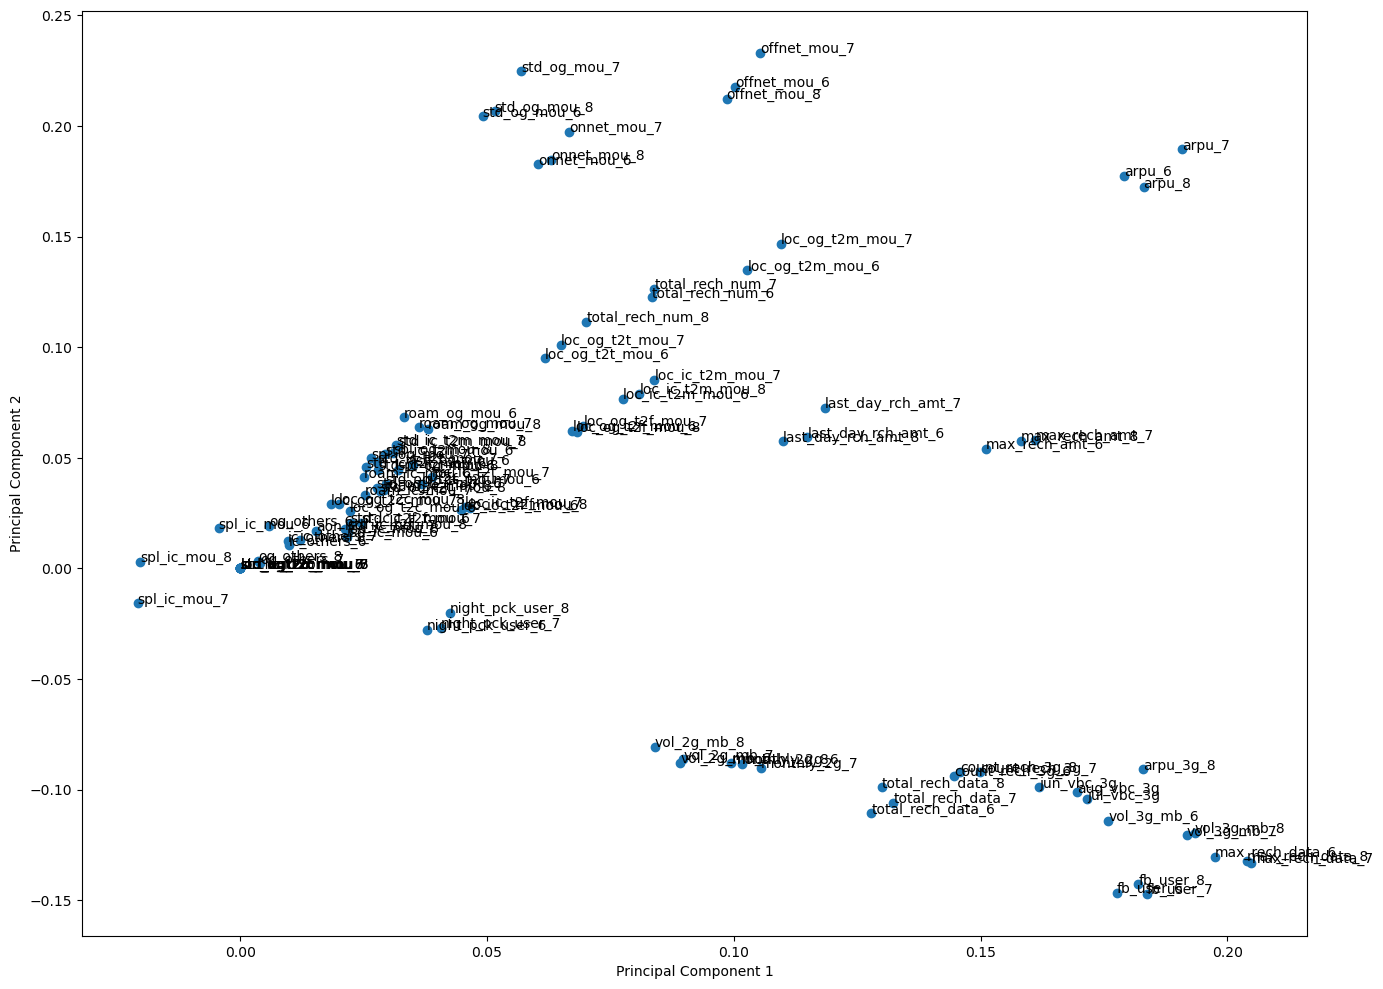

In [44]:
# Plotting PCA Components against each other
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(pca.components_[0], pca.components_[1])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
for i, txt in enumerate(churn_train_df.columns):
    ax.annotate(txt, (pca.components_[0][i], pca.components_[1][i]))
plt.tight_layout()
plt.show()


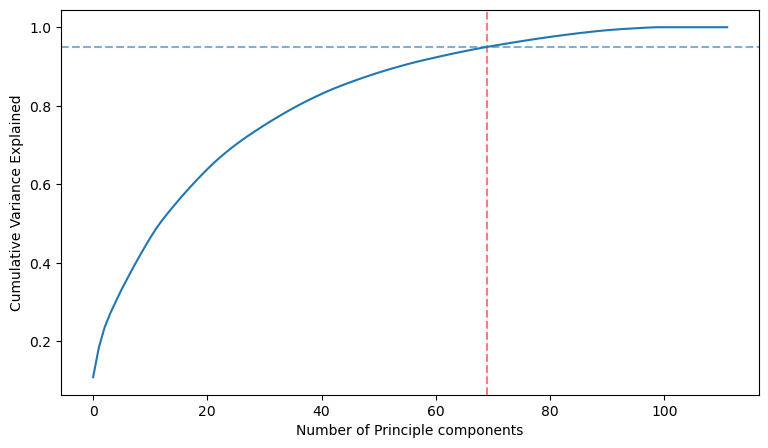

In [69]:
# Plotting explained_variance_ratio_
fig, ax = plt.subplots(figsize=(9, 5))
ax.axvline(x=69, ymax=1, ymin=0, color=pastel_colors[0], linestyle="--")
ax.axhline(y=0.95, xmax=198, xmin=0, color=pastel_colors[1], linestyle="--")
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel("Number of Principle components")
ax.set_ylabel("Cumulative Variance Explained")
plt.show()


So approximately 69 components are enough to describe 95% of the variance in the dataset. We'll choose 60 components for our modeling from hereon.

In [73]:
# Performing final PCA iteration
pca_final = IncrementalPCA(n_components=77)

# Fit and transform 
X_train_pca = pca_final.fit_transform(X_train)

# Finding correlation coefficient
corrmat = np.corrcoef(X_train_pca.T)

corrmat.shape

(77, 77)

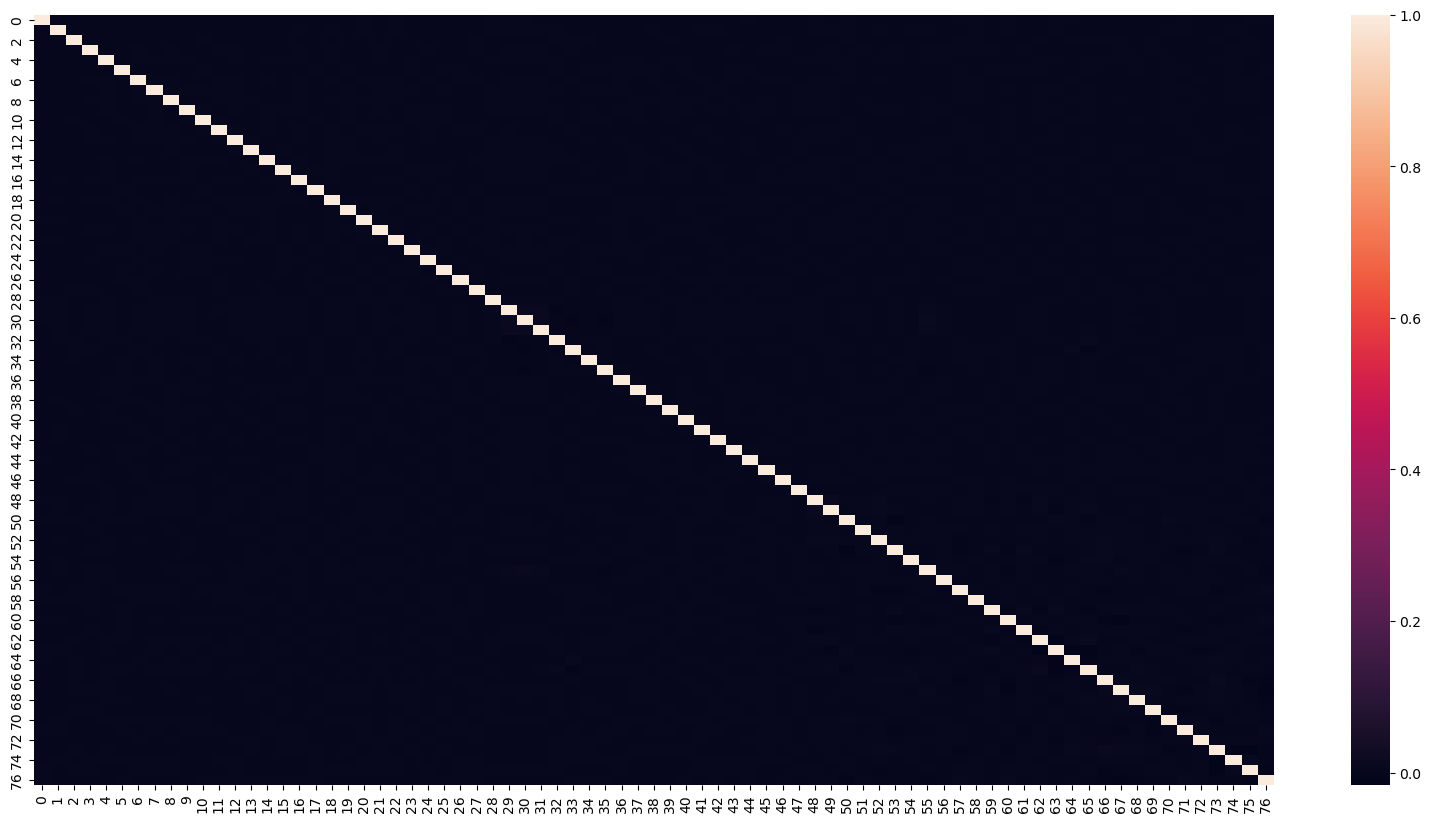

In [76]:
# Plotting heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corrmat)
plt.show()


In [ ]:
# TODO: Transform pca for test dataset
# X_test_pca = pca_final.transform(X_test)
# X_test_pca.shape


In [77]:
print("Size of earlier train dataset was :",X_train.shape)
print("Size of train dataset after PCA is:", X_train_pca.shape)

Size of earlier train dataset was : (69999, 112)
Size of train dataset after PCA is: (69999, 77)


# 6. Model Selection, Training, Prediction and Assessment

# 7. Hyperparameter Tuning/Model Improvement